[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/efficientcube/blob/main/notebooks/Rubik's_Cube.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/kyo-takano/efficientcube/blob/main/notebooks/Rubik's_Cube.ipynb)

# EfficientCube: Rubik's Cube

[![TMLR](https://img.shields.io/badge/TMLR_1188-112467?style=for-the-badge)](https://openreview.net/forum?id=bnBeNFB27b)
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=for-the-badge)](https://github.com/kyo-takano/efficientcube)

This notebook is associated with the following publication:
> K. Takano. Self-Supervision is All You Need for Solving Rubik's Cube. Transactions on Machine Learning Research, ISSN 2835-8856, 2023. URL: https://openreview.net/forum?id=bnBeNFB27b.

---

## Overview
This standalone notebook serves as a demonstration of the method proposed in the paper and provides the necessary code to reproduce the experiment. Please refer to the paper for the methodological overview and further details.

## Usage
For the demonstration purpose, the default number of training steps is set to `10000`, and the beam width for inference is set to `2**11`. To replicate our best-reported result, set `TrainConfig.num_steps = 2000000` and `SearchConfig.beam_width = 2**18`. However, note that it will likely take several days to complete both training and inference. If you wish to speed up the training/inference, the mixed precision mode can be enabled by setting `ENABLE_FP16` to `True`.

## Setup

In [1]:
# For beam search, we need to set the environment variable to allow for expandable segments
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [1]:
import sys
#sys.path.append("/home/f/fraser-talientec/")
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
import copy
from contextlib import nullcontext
from tqdm import tqdm, trange
from envsAndScramble import *
from NN_models import *
import gc

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 48
GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-893a4caf-922f-30c4-07da-80876ae1177a)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-c5756ae5-a021-3388-9981-eeb633a79d43)
GPU 2: NVIDIA GeForce RTX 3090 (UUID: GPU-0e25f05d-1050-dcd2-b356-aac749a96376)
GPU 3: NVIDIA GeForce RTX 3090 (UUID: GPU-e72fdc49-3e43-a094-1fcc-15ec675c8b5b)


In [2]:
# import importlib
# import envsAndScramble
# importlib.reload(envsAndScramble)
# from envsAndScramble import *

#Memory management helpers
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()

# Set CUDA memory settings
# torch.cuda.set_per_process_memory_fraction(0.95)  # Use 90% of available GPU memory
# clear_gpu_memory()
#torch.backends.cudnn.benchmark = True

print("GPU memory cleared.")


GPU memory cleared.


In [3]:
#n_symmetric =13

#env = PermutationGroup(n_symmetric)
env = Cube3()



env_name = env.__class__.__name__
class TrainConfig:
    #max_depth = 26                          # God's Number
    max_depth= 30#8*n_symmetric
    batch_size_per_depth = 200#was 200 for FFN#14#7#0#0#was 100 for big run
    num_steps = 1000000#added 0
    learning_rate = 3e-4
    INTERVAL_PLOT, INTERVAL_SAVE, INTERVAL_BACKUP = 100, 50000, 5000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster
    #SAVE_DIRECTORY = "~/Downloads/cube2d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    #SAVE_DIRECTORY = "/home/f/fraser-talientec/cube3d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    SAVE_DIRECTORY = "/mnt/extraspace/kitft/cube/"+env_name+"/"
    INTERVAL_VALIDATE = 100
    weight_decay = 1e-3
    max_grad_norm = 1
    name = env_name+"_max_depth_"+str(max_depth)
    dropout = 0.0
    time_embedding_dim = 64# was 64 for big run
    gradient_accumulation_steps = 1

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

# Ensure the save directory exists
if not os.path.exists(TrainConfig.SAVE_DIRECTORY):
    os.makedirs(TrainConfig.SAVE_DIRECTORY)



## Environment
Rubik's Cube is operated based on the locations and colors of 6$\times$9 stickers.

We employ [Quarter-Turn Metric](https://www.speedsolving.com/wiki/index.php/Metric#QTM) (90° turns count as one move; 180°, two) for both scrambling and solving the puzzle.


## Model

In [4]:
from NN_models import Model

# Count and print the number of parameters in the model
model = Model(width=1000, num_classes=env.num_classes, input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim, dropout_rate=TrainConfig.dropout,n_residual_blocks=4)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

model.to(device)

Total number of parameters in the model: 16,197,780


Model(
  (generator_embedding): Embedding(12, 64)
  (embedding): LinearBlock(
    (fc): Linear(in_features=324, out_features=5000, bias=True)
    (gelu): GELU(approximate='none')
    (ln): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=1000, out_features=1000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    )
    (2-5): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=1000, out_features=1000, bias=True)
          (gelu): GELU(approximate='none')
          (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        )
      )
      (time_proj): Linear(in_feat

In [5]:

# Initialize model
#print("input_dimension:", env.input_dim)
#print("state dimension:", env.state_dim)
#print("number of classes:", env.num_classes)
# model = TransformerModel(
#     #input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=TrainConfig.time_embedding_dim,
#     d_model=256,#256,#d_model/num_heads
#     nhead=4,
#     num_layers=8,
#     max_seq_len=env.state_dim,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout
# # )
# model = TransformerModel_RC(
#     #input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=TrainConfig.time_embedding_dim,
#     d_model=128,#256,#256,#d_model/num_heads
#     nhead=16,
#     num_layers=3,
#     max_seq_len=env.state_dim,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout,
#     dim_feedforward_transformer=512,
#     dim_MLP_end=1024,
# )
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters in the model: {total_params:,}")

# model.to(device)
# model(torch.tensor(env.state,device=device).unsqueeze(0).repeat(10,1),torch.tensor(0.0,device=device).unsqueeze(0).repeat(10))


In [6]:
#model(torch.tensor(np.ones((10,env.state_dim),dtype=np.int64),device=device),(torch.tensor(np.ones(10,),device=device)*0.01).float())
# model(torch.tensor([env.state]*10,device=device),(torch.tensor(np.ones(10,),device=device)*0.01).float())

## Training

In [7]:
from envsAndScramble import *
import importlib
import envsAndScramble
importlib.reload(envsAndScramble)
from envsAndScramble import *

In [8]:
# 


seed = np.random.randint(0,2**32-1)
print("Using seed:",seed)
# Create the DataLoader
dataloader = DataLoader(
    ScrambleGenerator(max_depth=TrainConfig.max_depth,
                      total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                      env=env,
                      seed=seed),
    num_workers=min(16,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
    batch_size=TrainConfig.batch_size_per_depth
)

iterator=(iter(dataloader))

dataloader_val = DataLoader(
    ScrambleGenerator(max_depth=TrainConfig.max_depth,
                      total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                      env=env,
                      seed=seed+2),  # Added a seed for reproducibility
    num_workers=min(16,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
    batch_size=TrainConfig.batch_size_per_depth,
)

iterator_val=(iter(dataloader_val))
hi_val=next(iterator_val)


Using seed: 3085611874


In [10]:
#xtest=next(iter(dataloader))[0]
# xtest = next(iterator)[0]
# print(xtest.shape)
# xtest_val=next(iter(dataloader_val))[0]
# batch_t = torch.linspace(0,1, steps=xtest_val.shape[1]).to(device)#.unsqueeze(0).repeat(batch_x.shape[0], 1).to(device)
# custom_loss(model, xtest_val, batch_t)

In [12]:
# TrainConfig.learning_rate = 3e-4
# TrainConfig.max_grad_norm = 1
# TrainConfig.weight_decay = 1e-10
# TrainConfig.dropout = 0.0
# TrainConfig.gradient_accumulation_steps=50
# #torch.autograd.set_detect_anomaly(True)
# model.to(device)


# #model = deepcopy(model_load).to(device)
# model,train_losses_dict = train(model, dataloader, dataloader_val,max_plot_val=30,warmup_frac=0.001)

In [13]:
# small transformer, 13 gradient accum steps, batch size 7
# model
# model

In [14]:
# !ls ~/cube3d/ -lsth
# #print('hi')


In [15]:
#with batch size 7, accum 13, regular FFN
#plot_loss_curves(train_losses_dict,maxval=2)

In [16]:
# losses_dict_loaded = np.load(os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30training_losses1733505875.npz'))
# # losses_dict_loaded['val_losses'][-1]
# plot_loss_curves(losses_dict_loaded)

In [17]:
!ls ~/cube3d/ -lsht

ls: cannot access '/mnt/users/kitft/cube3d/': No such file or directory


In [18]:
model_load = Model(width=1000, num_classes=env.num_classes,input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim,dropout_rate=TrainConfig.dropout)
# #model_load.load_state_dict(torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY, 'final_222000_trained_model.pth')))
# #model_load.load_state_dict(torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30_FF_residual_model_16M_1000000steps_1736346016.pth')))

#model_load.load_state_dict(torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30_FF_residual_model_16M1737056670_backup.pth')))
model_load.load_state_dict(torch.load(os.path.join("/mnt/users/kitft", 'Cube3_max_depth_30_FF_residual_model_16M1737056670_backup.pth')))


model = model_load.to(device)


#model_load.load_state_dict(torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30_48000p100000p100000p231000steps_1733612677.pth')))

/tmp/ipykernel_253598/3817367850.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load.load_state_dict(torch.load(os.path.join("/mnt/users/kitft", 'Cube3_max_depth_

In [19]:
# #model_load = Model(width=1000, num_classes=env.num_classes,input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim,dropout_rate=TrainConfig.dropout)
# model_load_trans = TransformerModel(
#     input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=TrainConfig.time_embedding_dim,
#     d_model=256,#256,#d_model/num_heads
#     nhead=4,
#     num_layers=8,
#     max_seq_len=env.state_dim,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout
# )
# #ihere=3000
# #model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, TrainConfig.name+f"{ihere}steps.pth")
# model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30_TransformerEncoderModel_6M250000steps.pth')
# #model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_26_60000steps_1733419476.pth')
# model_load_trans.load_state_dict(torch.load(model_name_load))
# model_load_trans.to(device)
# model = model_load_trans.to(device)

In [20]:
# model_load_spiky = Model(width=1000, num_classes=env.num_classes,input_dim=env.input_dim, time_embedding_dim=20,dropout_rate=TrainConfig.dropout)
# #ihere=3000
# #model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, TrainConfig.name+f"{ihere}steps.pth")
# model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_26_60000steps_1733419476.pth')
# model_load_spiky.load_state_dict(torch.load(model_name_load))

In [21]:
# model_load = Model(width=1000, num_classes=env.num_classes,input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim,dropout_rate=TrainConfig.dropout)
# ihere=48000
# model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, TrainConfig.name+f"{ihere}steps.pth")
# #model_name_load =  os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_26_60000steps_1733419476.pth')
# model_load.load_state_dict(torch.load(model_name_load))

In [22]:
!ls ~/.fonts/Serif

cmunbi.eot   cmunbx.eot   cmunrm.eot   cmun-serif.css  cmunti.woff
cmunbi.svg   cmunbx.svg   cmunrm.svg   cmunti.eot      OFL-FAQ.txt
cmunbi.ttf   cmunbx.ttf   cmunrm.ttf   cmunti.svg      OFL.txt
cmunbi.woff  cmunbx.woff  cmunrm.woff  cmunti.ttf      README.txt


In [23]:
# # Download and install CMU Serif fonts
# #!wget https://fontlibrary.org/assets/downloads/cmu-serif/59c4efc3fa08079ca44060ca808c8f58/cmu-serif.zip
# #!unzip cmu-serif.zip -d ~/.fonts/
# # Check if CMU Serif font is installed
# !fc-list | grep -i "cmu serif"
# # Check if CMU Serif is in available fonts
# import matplotlib.font_manager as fm

# # Add CMU Serif font files
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunrm.ttf'))  # Regular
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunbx.ttf'))  # Bold
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunti.ttf'))  # Italic
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunbi.ttf'))  # Bold Italic

# # Rebuild the font cache
# # fm._rebuild()

# # Check if CMU Serif is now available
# fonts = [f.name for f in fm.fontManager.ttflist]
# print("CMU Serif available:", any("CMU Serif" in font for font in fonts))

# # Print all fonts containing "CMU"
# cmu_fonts = [f for f in fonts if "CMU" in f]
# print("\nAll CMU fonts found:")
# for f in cmu_fonts:

#     print(f)


In [24]:
# filenames = [
#     'Cube3_max_depth_30training_losses1733505875.npz',
#     'Cube3_max_depth_30training_losses1733531789.npz', 
#     'Cube3_max_depth_30training_losses1733531816.npz',
#     'Cube3_max_depth_30training_losses1733571302.npz',
#     'Cube3_max_depth_30training_losses1733612585.npz',
#     'Cube3_max_depth_30training_losses1733612677.npz',
#     'Cube3_max_depth_30training_losses1733737137.npz'
# ]


In [25]:
# # Load and plot all training histories sequentially
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set CMU font family
# plt.rcParams['font.family'] = 'CMU Serif'
# plt.rcParams['mathtext.fontset'] = 'cm'
# # sns.set_theme(font='CMU Serif')

# # Set style
# plt.style.use(['seaborn-v0_8-whitegrid', 'seaborn-v0_8-paper'])
# plt.rcParams['font.family'] = 'CMU Serif'
# #sns.set_palette("deep")

# filenames = [
#     'Cube3_max_depth_30training_losses1733505875.npz',
#     'Cube3_max_depth_30training_losses1733531789.npz', 
#     'Cube3_max_depth_30training_losses1733531816.npz',
#     'Cube3_max_depth_30training_losses1733571302.npz',
#     'Cube3_max_depth_30training_losses1733612585.npz',
#     'Cube3_max_depth_30training_losses1733612677.npz',
#     'Cube3_max_depth_30training_losses1733737137.npz'
# ]

# fig, ax = plt.subplots(figsize=(10,6))
# offset = 0
# train_color = "blue"
# val_color = "orange"

# for f in filenames:
#     data = np.load(os.path.join(TrainConfig.SAVE_DIRECTORY, f))
#     train_losses = data['train_losses']
#     val_losses = data['val_losses']
    
#     train_steps = np.arange(len(train_losses)) + offset
#     val_steps = np.arange(0, len(train_losses), 100) + offset+1
#     if val_steps[0]==1:
#         val_steps = np.insert(val_steps, 1, 20)
#         val_losses = np.insert(val_losses, 1, 24)
    
#     ax.plot(train_steps, train_losses, color=train_color, alpha=0.7,
#             label=f'Train {f[-13:-4]}', linewidth=1.5)
#     ax.plot(val_steps, val_losses, color=val_color, alpha=0.7,
#             label=f'Val {f[-13:-4]}', linewidth=1.5)
    
#     if offset > 0:
#         ax.axvline(x=offset, color='blue', linestyle='solid', alpha=0.1)
    
#     offset += len(train_losses)
#     print((offset))

# ax.set_xlabel('Training Steps', fontsize=12)
# ax.set_ylabel('Loss', fontsize=12) 
# ax.set_title(f'Training and Validation Losses ({offset} steps)', fontsize=14)
# ax.set_xscale("log")

# # Customize grid
# ax.grid(True, linestyle='--', alpha=0.7)

# # Customize legend
# #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
# #         frameon=True, fancybox=True, shadow=True)
# # Create custom legend with just Train and Val
# handles = [
#     plt.Line2D([], [], color=train_color, label='Train', alpha=0.7, linewidth=1.5),
#     plt.Line2D([], [], color=val_color, label='Val', alpha=0.7, linewidth=1.5)
# ]
# ax.legend(handles=handles, frameon=True, fancybox=True, shadow=True,loc='upper right',fontsize=12)
# # Plot train_losses_dict on top of the original plot
# if 'train_losses_dict' in locals():
#     train_losses = train_losses_dict['train_losses']
#     train_losses_aux = train_losses_dict['train_losses_aux'] 
#     val_losses = train_losses_dict['val_losses']
    
#     val_steps = list(range(0, len(train_losses), TrainConfig.INTERVAL_VALIDATE))
#     val_steps[0] = 1  # move to 1
    
#     ax.plot(train_losses, label='Training Loss', color='green')
#     ax.plot(val_steps, val_losses, label='Validation Loss', color='red')
    
#     ax.set_ylim(max(min(min(train_losses), min(val_losses),min(train_losses_aux)) - 1,-10), 30)
#     ax.legend()



# # Adjust layout and display
# plt.tight_layout()
# plt.show()

# # # Store last filename for model loading
# # model_name_load_231000 = os.path.join(TrainConfig.SAVE_DIRECTORY, filenames[-1])

In [26]:
# #model_load_231000 = Model(width=1000, num_classes=env.num_classes,input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim,dropout_rate=TrainConfig.dropout)

# model_load_231000= copy.deepcopy(model).to(device)
# ihere=222000
# model_name_load_231000 =  os.path.join(TrainConfig.SAVE_DIRECTORY, TrainConfig.name+f"{ihere}steps.pth")
# #model_name_load_231000 =  os.path.join(TrainConfig.SAVE_DIRECTORY, 'Cube3_max_depth_30_48000p100000p100000p231000steps_1733612677.pth')
# model_load_231000.load_state_dict(torch.load(model_name_load_231000))

In [27]:
#torch.save(model.state_dict(), os.path.join(TrainConfig.SAVE_DIRECTORY,'final_343000_trained_model_transformer.pth'))
#torch.save(model.state_dict(), os.path.join('/tmp/','final_300000_trained_model_transformer.pth'))
#model = torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY,'final_343000_trained_model_transformer.pth'))
# model.load_state_dict(torch.load(os.path.join(TrainConfig.SAVE_DIRECTORY,'final_343000_trained_model_transformer.pth')))
# model.to(device)

In [28]:
# Clear GPU memory
import torch

# Empty CUDA cache
torch.cuda.empty_cache()

# Reset peak memory stats
torch.cuda.reset_peak_memory_stats()

# Optional: Force garbage collection
import gc
gc.collect()


print("GPU memory cleared.")


GPU memory cleared.


In [29]:
def calculate_validation_loss(dataloader_val, model, num_batches=1):
    """
    Calculate validation loss over specified number of batches.
    
    Args:
        dataloader_val: Validation dataloader
        model: Model to evaluate
        num_batches: Number of batches to use for validation
    
    Returns:
        Average loss over all batches
    """
    device = next(model.parameters()).device
    model = model.to(device)
    model.eval() # Put in eval mode - for dropout/norm if present
    
    total_loss = 0
    total_trajectories = 0
    
    # Process batches in chunks of 10 to avoid memory issues
    chunk_size = min(10, num_batches)
    num_chunks = (num_batches + chunk_size - 1) // chunk_size
    
    with torch.no_grad():
        for chunk in range(num_chunks):
            x_testing = []
            start_batch = chunk * chunk_size
            end_batch = min((chunk + 1) * chunk_size, num_batches)
            
            # Collect batches for this chunk
            for i, batch in enumerate(dataloader_val):
                if i >= end_batch:
                    break
                if i >= start_batch:
                    x_testing.append(batch[0])
                    
            if not x_testing:  # Skip if no batches collected
                continue
                
            x_testing = torch.cat(x_testing, dim=0).to(device)
            num_steps = TrainConfig.max_depth
            batch_t = torch.linspace(1/num_steps, 1, steps=num_steps, device=device)
            batch_t = batch_t.unsqueeze(0).repeat(x_testing.shape[0], 1)
            
            loss = custom_loss_discrete(model, x_testing, batch_t)
            total_loss += loss.item() * x_testing.shape[0]
            total_trajectories += x_testing.shape[0]
            
            # Free memory
            del x_testing, batch_t
            torch.cuda.empty_cache()
    
    avg_loss = total_loss / total_trajectories
    print(f"Validation loss: {avg_loss:.4f} (calculated over {total_trajectories} trajectories)")
    return avg_loss

# Example usage:
calculate_validation_loss(dataloader_val, model, num_batches=1)

x_testing shape: torch.Size([200, 30, 54])
torch.Size([200, 30])
tensor(0.4989, device='cuda:0')


In [30]:
from envsAndScramble import Cube3
from sympy import primerange


# Get all states 5 moves away
if env.__class__.__name__ == 'Cube3' or env.__class__.__name__ == 'Cube2':
    steps_away = 5
    states_close_to_finish = get_states_n_moves_away_CUBE(steps_away)
    states_close_to_finish = np.unique(states_close_to_finish, axis=0)
elif env.__class__.__name__ in ['PermutationGroup','envsAndScramble.PermutationGroup']:
    steps_away = 3
    states_close_to_finish = get_states_n_moves_away_GROUP(steps_away)
    states_close_to_finish = np.unique(states_close_to_finish, axis=0)
else:
    raise TypeError(f"env must be an instance of Cube3 or PermutationGroup, actually is: {type(env).__name__}")

# Debug print to check the type of env
print(f"Type of env: {type(env)}")
print(f"Is instance of PermutationGroup: {isinstance(env, envsAndScramble.PermutationGroup)}")
print(f"Is instance of Cube3: {isinstance(env, envsAndScramble.Cube3)}")

print(f"Number of unique states {steps_away} moves away: {len(set(map(tuple, states_close_to_finish)))}")
print(f"Total number of states (including duplicates): {len(states_close_to_finish)}")

# Convert states_4_moves to a set of hashed states for efficient lookup
hashed_states_close_to_finish = set(hash_state(state) for state in states_close_to_finish)
hashed_states_close_to_finish_torch = torch.vmap(hash_vectors_torch)(torch.tensor(states_close_to_finish)).to(device)
torch_states_close_to_finish = torch.tensor(states_close_to_finish).to(device)

if env.__class__.__name__ == 'Cube3':   
    # Example usage:
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L','B','R'])  # Apply a short scramble
    print(env.state)
    print("Cube3: Is the scrambled state in our list?", is_state_in_short_distance(env.state))

    # Try with a random state (likely not in our list)
    random_state = np.random.randint(0, 6, size=54)
    print("Is a random state in our list?", is_state_in_short_distance(random_state))
# Example usage with torch tensors:
if env.__class__.__name__ == 'Cube3':
    print("\ntorch")
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L','B','R'])  # Apply a short scramble
    state_tensor = torch.tensor(env.state, device=device)
    print("Cube3: Is the scrambled state in our list (torch)?", is_state_in_short_distance_torch(state_tensor))
    print("Cube3: Is the scrambled state in our list (actual)?", is_state_actually_in_list_torch(state_tensor))

    # Try with a random state (likely not in our list)
    random_state_tensor = torch.randint(0, 6, (54,), device=device)
    print("Is a random state in our list (torch)?", is_state_in_short_distance_torch(random_state_tensor))
    print("Is a random state in our list (actual)?", is_state_actually_in_list_torch(random_state_tensor))
    # Try with a batch of states
    batch_size = 3
    batch_states = torch.stack([state_tensor, random_state_tensor, state_tensor])
    print("Results for batch of states (torch):", is_state_in_short_distance_torch(batch_states))

if env.__class__.__name__ == 'Cube2':
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L'])  # Apply a short scramble
    print(env.state)
    print("Cube2: Is the scrambled state in our list?", is_state_in_short_distance(env.state))

elif env.__class__.__name__ == 'PermutationGroup':
    # Apply a sequence of moves using the PermutationGroup methods
    state = env.identity.copy()
    moves = [0, 1, 2]  # Indices of moves to apply
    for move_index in moves:
        state = env.apply_move_fast(state, move_index)
    
    print("Scrambled state:", state)
    print("PermutationGroup: Is the scrambled state in our list?", is_state_in_short_distance(state))

    # Generate a random state``
    random_state, _ = env.scramble_fast(5)  # Apply 5 random moves
    print("random_state:", random_state)
    print("PermutationGroup: Is a random state in our list?", is_state_in_short_distance(random_state))

# Compare lengths to check for hash collisions
print("Number of original states:", len(states_close_to_finish))
print("Number of hashed states:", len(set(hashed_states_close_to_finish)))

if len(states_close_to_finish) > len(set(hashed_states_close_to_finish)):
    print("WARNING: Hash collisions detected!")
    print("Number of collisions:", len(states_close_to_finish) - len(set(hashed_states_close_to_finish)))
else:
    print("No hash collisions detected")




Type of env: <class 'envsAndScramble.Cube3'>
Is instance of PermutationGroup: False
Is instance of Cube3: False
Number of unique states 5 moves away: 94920
Total number of states (including duplicates): 94920
[1 4 5 0 0 1 5 5 2 0 5 0 2 1 1 4 4 1 4 0 0 2 2 0 4 4 4 5 3 3 2 3 3 2 5 5 1
 0 0 1 4 4 2 3 3 3 3 3 5 5 2 2 1 1]
Cube3: Is the scrambled state in our list? True
Is a random state in our list? False

torch
Cube3: Is the scrambled state in our list (torch)? tensor([True], device='cuda:0')
Cube3: Is the scrambled state in our list (actual)? tensor(True, device='cuda:0')
Is a random state in our list (torch)? tensor([False], device='cuda:0')
Is a random state in our list (actual)? tensor(False, device='cuda:0')
Results for batch of states (torch): tensor([ True, False,  True], device='cuda:0')
Number of original states: 94920
Number of hashed states: 94920
No hash collisions detected


In [31]:
# # Let's track the values through each layer
# position = 2
# step = 4
# state = sample_states[position][step]
# timeval = batch_t[position,step:step+1]
# testval=(model(state,timeval))
# print(testval)
# print(torch.max(testval))
# # print("After generator embedding:", time_emb.shape, time_emb.max().item())
# x = nn.functional.one_hot(state, num_classes=env.num_classes).to(torch.float)
# x = x.reshape(-1, env.input_dim)

# # Initial embedding layer (324 -> 5000)
# x = model_load_spiky.embedding(x)
# print("After initial embedding:", x.shape, x.max().item())

# # First linear layer (5000 -> 1000) 
# x = model_load_spiky.layers[0](x)
# print("After first linear layer:", x.shape, x.max().item())

# # Track through residual blocks
# for i, block in enumerate(model_load_spiky.layers[1:]):
#     x = block.forward(x,timeval)
#     # x_prev = x
#     # time_emb = sinusoidal_position_embedding(timeval, block.time_proj.in_features)
#     # time_proj = block.time_proj(time_emb)
#     # x = block.layers[0](x + time_proj)
#     # x = block.layers[1](x)
#     # x = x + x_prev
#     print(f"After residual block {i}:", x.shape, x.max().item())


# for i, block in enumerate(model_load_spiky.output):
#     x = block(x)
#     print(f"After output layer {i}:", x.shape, x.max().item())

# print("Final output:", x.shape, x.max().item())

Testing model2 predictions on sample states:
Loss:  tensor(1.5389, device='cuda:0')
tensor([[5.5947e-04, 5.5832e-04, 5.5925e-04, 5.5863e-04, 5.6090e-04, 5.6071e-04,
         5.6248e-04, 9.9384e-01, 5.5903e-04, 5.6315e-04, 5.5836e-04, 5.5835e-04],
        [6.1773e-04, 6.1721e-04, 6.1725e-04, 6.1713e-04, 6.1744e-04, 6.1919e-04,
         6.1733e-04, 6.1663e-04, 6.1953e-04, 6.2057e-04, 9.9320e-01, 6.2037e-04],
        [6.1486e-04, 6.1536e-04, 6.1439e-04, 6.1391e-04, 6.1556e-04, 9.9323e-01,
         6.1655e-04, 6.1661e-04, 6.1597e-04, 6.1398e-04, 6.1826e-04, 6.1381e-04],
        [6.3801e-04, 6.3883e-04, 6.3815e-04, 6.3685e-04, 6.4075e-04, 4.9839e-01,
         6.4844e-04, 4.9521e-01, 6.4009e-04, 6.4265e-04, 6.3939e-04, 6.3663e-04],
        [6.7740e-04, 6.7834e-04, 6.7845e-04, 6.7894e-04, 6.7722e-04, 6.7945e-04,
         6.7727e-04, 6.7791e-04, 9.9254e-01, 6.7964e-04, 6.7880e-04, 6.7865e-04],
        [6.0900e-04, 6.0896e-04, 6.0900e-04, 6.1109e-04, 6.0817e-04, 6.1253e-04,
         6.0846e-04,

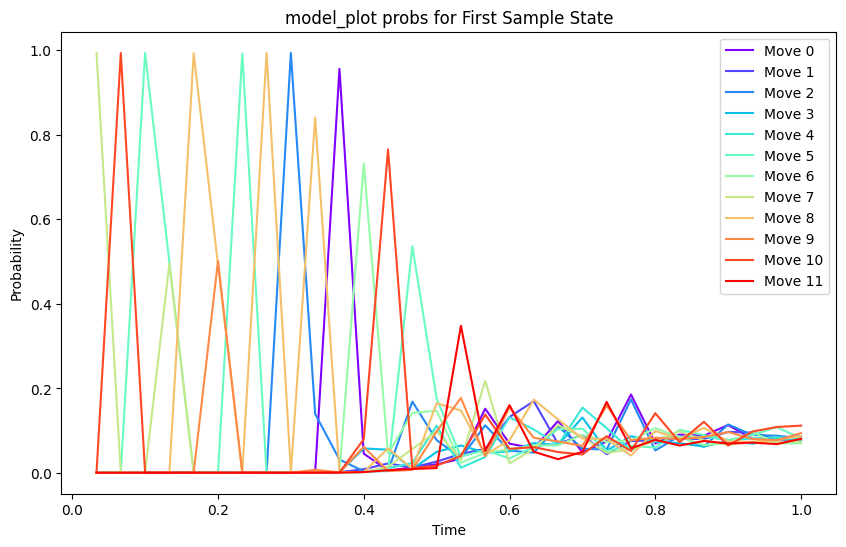

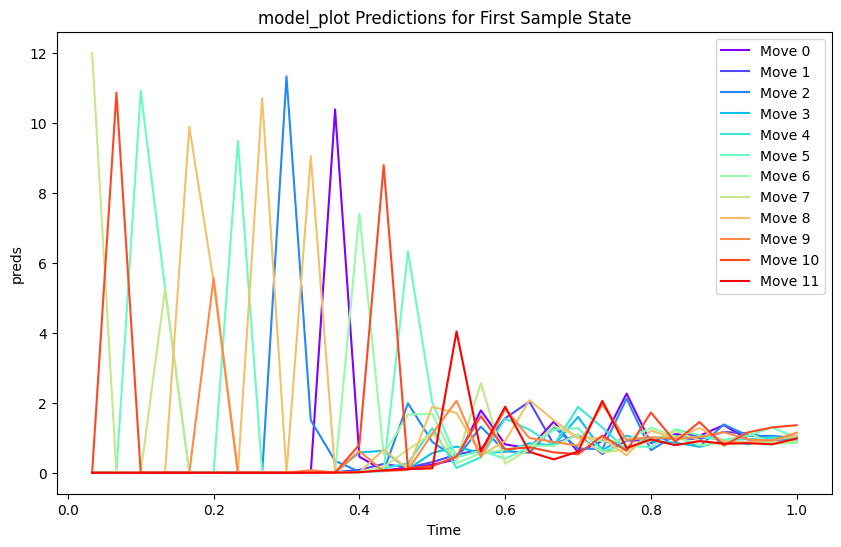

In [32]:
# model2
# Test model2 predictions on some states
model_plot=model.to(device)
xtest = next(iter(dataloader_val))[0]
print("Testing model2 predictions on sample states:")
#sample_states=saved[12:13].to(device)
sample_states=xtest[0:10].to(device)
with torch.no_grad():
    model_plot.eval()
    batch_t = torch.linspace(0 +1/sample_states.shape[1],1, steps=sample_states.shape[1]).to(device).unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)#.unsqueeze(0).repeat(batch_x.shape[0], 1).to(device)
    loss = custom_loss_discrete(model_plot, sample_states, batch_t)
print("Loss: ",loss)

sample_states.shape

# Create a sample batch of cube states
#sample_states = torch.randint(0, 6, (5, 54)).to(device)  # 5 random cube states
# sample_states=hi.to(device)

sample_states_test=sample_states[0].to(device)
#sample_states_test=torch.tensor(test_scrambles[0]).to(device)


# Create time steps
t = torch.linspace(1/TrainConfig.max_depth,1,steps=TrainConfig.max_depth).to(device)#.unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)

# Get model2 predictions
with torch.no_grad():
    model_plot.train()
    predictions = model_plot(sample_states_test, t)#.cpu().detach().numpy()
probabilities = predictions/predictions.sum(axis=-1, keepdims=True)
#print(predictions)
print(probabilities)
#`print("worst is: ", probabilities[5,1])
print(f"Max probability: {probabilities.max().item():.4f}")
print(f"Min probability: {probabilities.min().item():.4f}")
# Print shape of predictions
print(f"Shape of predictions: {probabilities.shape}")

# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, probabilities[:, i].cpu().numpy(), label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot probs for First Sample State")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.show()


# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, predictions[:, i].cpu().numpy(), label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot Predictions for First Sample State")
plt.xlabel("Time")
plt.ylabel("preds")
plt.legend()
plt.show()

# Print the most likely move at the beginning and end of the time sequence for each state
# print("\nMost likely moves:")
# for i in range(5):
#     start_move = torch.argmax(predictions[i, 0, :]).item()
#     end_move = torch.argmax(predictions[i, -1, :]).item()
#     print(f"State {i+1}: Start: Move {start_move}, End: Move {end_move}")


In [33]:
!cd {TrainConfig.SAVE_DIRECTORY}
if True:#"DeepCubeA"!=os.path.join(TrainConfig.SAVE_DIRECTORY, "DeepCubeA").split("/")[-1]:
    if not os.path.exists(os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')):
        !wget -q https://github.com/forestagostinelli/DeepCubeA/archive/refs/heads/master.zip && unzip -q master.zip && mv DeepCubeA-master {os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')} && rm master.zip
    %cd {os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')}
# !cd ~/cube3d
# from environments import *
# %cd cube3d/DeepCubeA


print('### Optimal Solver ###')
filename = os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA/data/cube3/test/data_0.pkl')
with open(filename, 'rb') as f:
    result_Optimal = pickle.load(f)  # Force load pickle data even with missing modules

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i)
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA/results/cube3/results.pkl')
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")


/mnt/extraspace/kitft/cube/Cube3/DeepCubeA
### Optimal Solver ###
dict_keys(['states', 'times', 'solutions', 'num_nodes_generated'])
No. of cases: 1000

### DeepCubeA ###


/mnt/users/kitft/torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 1000
/mnt/extraspace/kitft/cube/Cube3
Example:
[['D', -1], ['F', 1], ['R', 1], ['U', -1], ['F', 1], ['F', 1], ['R', 1], ['U', 1], ['F', 1], ['R', 1], ['B', -1], ['R', -1], ['F', -1], ['R', -1], ['D', -1], ['U', -1], ['R', -1], ['U', -1], ['U', -1], ['R', -1], ['U', 1], ['B', -1]]
-> ['B', "U'", 'R', 'U', 'U', 'R', 'U', 'D', 'R', 'F', 'R', 'B', "R'", "F'", "U'", "R'", "F'", "F'", 'U', "R'", "F'", 'D']


In [34]:
# #Create K test scrambles by randomly sampling N moves each
# K = 100  # Number of scrambles to generate
# N = TrainConfig.max_depth    # Number of moves per scramble
# test_scrambles = [
#     [random.choice(env.moves) for _ in range(N)] 
#     for _ in range(K)
# ]

In [35]:
# model_test = model.to(device)

# # Get a bunch of scrambles and test the model
# num_scrambles = 100
# num_iterations=2

# #max_moves_scramble = 26
# temp_depth_to_search = TrainConfig.max_depth
# depth_to_search =TrainConfig.max_depth  # TrainConfig.max_depth
# success_count = 0
# failure_count = 0
# total_steps = 0  # To keep track of the total number of steps taken to solve

# for i in range(10):#num_scrambles):
#     print('\n')
#     # Initialize environment - either Cube2 or PermutationGroup(13)
#     use_cube = True  # Toggle between Cube2 and PermutationGroup
    
#     if use_cube:
#         env = Cube3()
#         env.reset()
#         # Apply test scramble sequence
#         env.apply_scramble(test_scrambles[i][0:])
#         state = env.state.copy()
#         initial_state = state.copy()
#     else:
#         env = PermutationGroup(13)
#         # Option 1: Use test scramble sequence
#         state = env.identity.copy()
#         for move in test_scrambles[i]:
#             state = env.apply_move(state, move)
            
#         # Option 2: Use random permutation
#         # state = np.random.permutation(env.identity)
        
#         initial_state = state.copy()

#     # Convert state to tensor for model input
#     #state_tensor = torch.tensor(initial_state, device=device).unsqueeze(0)
#     state = state
    
#     # Try to solve using the model
#     solved = False
#     for j in range(num_iterations):
#         #print(env.state)
#         for step in range(temp_depth_to_search):  # Allow twice the number of scramble moves for solving
#             #print(env.state)
#             with torch.no_grad():
#                 t = torch.tensor([((temp_depth_to_search) - step) / (depth_to_search)], device=device)
#                 #print(t)
#                 model_test.eval()
#                 #state_tensor = torch.tensor(env.state, device=device).unsqueeze(0)
#                 state_tensor = torch.tensor(env.state, device=device).unsqueeze(0)
#                 #prediction = model_test(state_tensor, t)
#                 prediction = model_test(state_tensor, t)
#                 #print(prediction)
#                 #prediction = torch.rand(env.num_moves).to(device)
#             move = torch.argmax(prediction).item()# definitely should be move, not inverse_move
#             #print(env.state)
#             #inverse_move = get_move_inverse_GROUP(move)
#             #print(move)
#             #print(state_tensor.cpu().numpy())

#             #state = env.apply_move_fast(state_tensor.cpu().numpy()[0], move) 
#             env.finger_ix(move)

#             # Check if the cube is solved
#             #if env.is_solved():
#             #print(env.state[0:3])
#             if is_state_in_short_distance(env.state):
#                 #if is_state_in_short_distance(state):
#                 solved = True
#                 success_count += 1
#                 total_steps += (step + 1)  # Add the number of steps taken to solve
#                 print(f"Scramble {i+1}: Solved in {step+1} moves on iteration {i+1}")
#                 #print(scrambled_state)
#                 break
#         if solved:
#             break
    
#     if not solved:
#         failure_count += 1
#         print(f"Scramble {i}: Failed to solve after {j+1} iterations")

# # Calculate the average number of steps taken to solve
# average_steps = total_steps / success_count if success_count > 0 else float('inf')

# print(f"\nResults:")
# print(f"Total scrambles: {num_scrambles}")
# print(f"Successes: {success_count}")
# print(f"Failures: {failure_count}")
# print(f"Success rate: {success_count/num_scrambles:.2%}")
# print(f"Average number of steps to solve: {average_steps:.2f}")



Scramble 1: Solved in 25 moves on iteration 1


Scramble 1: Failed to solve after 2 iterations


Scramble 2: Failed to solve after 2 iterations


Scramble 4: Solved in 28 moves on iteration 4


Scramble 4: Failed to solve after 2 iterations


Scramble 5: Failed to solve after 2 iterations


Scramble 6: Failed to solve after 2 iterations


Scramble 7: Failed to solve after 2 iterations


Scramble 8: Failed to solve after 2 iterations


Scramble 9: Failed to solve after 2 iterations

Results:
Total scrambles: 100
Successes: 2
Failures: 8
Success rate: 2.00%
Average number of steps to solve: 26.50


In [36]:
# # Create a 2D visualization of the cube solving process using UMAP dimensionality reduction
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import numpy as np

# for n_points in [10000]:
#     # Extract 1 million samples from data_loader and convert to numpy array
#     samples = []
#     for i, batch in enumerate(dataloader):
#         if i * batch[0].shape[0] >= n_points:
#             break
#         samples.append(batch[0].numpy())
#     data = np.concatenate(samples)[:n_points]
#     # Add solved state as first state for each trajectory
#     solved_state = env.goal
    
#     solved_states = np.tile(solved_state, (data.shape[0], 1))  # Repeat solved state for each trajectory
#     solved_states = solved_states.reshape(-1, 1, solved_state.shape[0])  # Add trajectory dimension
#     data = np.concatenate([solved_states, data], axis=1)  # Prepend solved state to each trajectory

#     position_vals = range(data.shape[-2])
#     position_vals = np.tile(position_vals, (data.shape[0], 1))
#     position_vals = position_vals.reshape(data.shape[0], position_vals.shape[1],1)  # Add trajectory dimension
#     position_vals
    
#     #data = np.concatenate([position_vals, data], axis=2)



#     for n_epochs in [2000]:
#         for metric in ["hamming", "euclidean","cosine","manhattan"]:  # Metrics suitable for discrete state spaces like Rubik's cube

#             # Create UMAP embedding
#             ncomponents = 2
#             reducer = umap.UMAP(n_components=ncomponents,metric =metric,n_epochs=n_epochs,min_dist=0.5)
#             embedding = reducer.fit_transform(np.concatenate(data),np.concatenate(position_vals))
#             embedding = embedding.reshape(-1, np.shape(data)[1], ncomponents)
#             embedding_to_plot = embedding[:20]

#             # Create scatter plot
#             plt.figure(figsize=(10,8))

#             # Plot all points
#             plt.scatter(embedding_to_plot.reshape(-1, ncomponents)[:,0], 
#                        embedding_to_plot.reshape(-1, ncomponents)[:,1],
#                        alpha=0.3, c='lightgray', s=20)

#             # Highlight start (solved) state

#             # Draw lines only for trajectory points
#             for traj_idx in range(embedding_to_plot.shape[0]):
#                 trajectory = embedding_to_plot[traj_idx]
#                 # Draw lines connecting consecutive points in this trajectory
#                 for i in range(len(trajectory)-1):
#                     plt.plot([trajectory[i,0], trajectory[i+1,0]], 
#                             [trajectory[i,1], trajectory[i+1,1]],
#                             color='blue', alpha=0.2, linestyle='-', linewidth=1)
#                 # Highlight points in trajectory
#                 plt.scatter(trajectory[:,0], trajectory[:,1], 
#                            alpha=0.6, c=np.arange(len(trajectory)), 
#                            cmap='viridis', s=30)
#             plt.scatter(embedding_to_plot[0,0,0], embedding_to_plot[0,0,1], c='red', s=100, label='Solved State')

#             # Add labels and title
#             plt.colorbar(label='Step Number')
#             plt.title(f'2D UMAP Embedding of Cube Solving Process with {metric} metric and {n_epochs} epochs and {n_points} points')
#             plt.xlabel('UMAP Dimension 1')
#             plt.ylabel('UMAP Dimension 2')
#             plt.legend()

#             plt.show()


## Inference

We test and compare on the DeepCubeA dataset

### Dataset: DeepCubeA

Downloading from GitHub

In [37]:
# !git clone -q https://github.com/forestagostinelli/DeepCubeA {deepcube_dir}

In [38]:
# if "DeepCubeA" not in os.getcwd():
#     save_dir = TrainConfig.SAVE_DIRECTORY
#     deepcube_dir = os.path.join(save_dir, 'DeepCubeA')
#     if not os.path.exists(deepcube_dir):
#         !git clone -q https://github.com/forestagostinelli/DeepCubeA {deepcube_dir}
#     os.chdir(deepcube_dir)

# print('### Optimal Solver ###')
# filename = 'data/cube3/test/data_0.pkl'
# with open(filename, 'rb') as f:
#     result_Optimal = pickle.load(f)

#     print(result_Optimal.keys())
#     result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
#     result_Optimal["solution_lengths_count"] = {
#         i: result_Optimal["solution_lengths"].count(i)
#         for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
#     }

#     print('No. of cases:', len(result_Optimal["solution_lengths"]))

# print('\n### DeepCubeA ###')
# filename = 'results/cube3/results.pkl'
# with open(filename, 'rb') as f:
#     result_DeepCubeA = pickle.load(f)

#     print(result_DeepCubeA.keys())
#     result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
#     result_DeepCubeA["solution_lengths_count"] = {
#         i: result_DeepCubeA["solution_lengths"].count(i)
#         for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
#     }

#     print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

# %cd ../

In [39]:
# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")

Example:
[['D', -1], ['F', 1], ['R', 1], ['U', -1], ['F', 1], ['F', 1], ['R', 1], ['U', 1], ['F', 1], ['R', 1], ['B', -1], ['R', -1], ['F', -1], ['R', -1], ['D', -1], ['U', -1], ['R', -1], ['U', -1], ['U', -1], ['R', -1], ['U', 1], ['B', -1]]
-> ['B', "U'", 'R', 'U', 'U', 'R', 'U', 'D', 'R', 'F', 'R', 'B', "R'", "F'", "U'", "R'", "F'", "F'", 'U', "R'", "F'", 'D']


### Beam Search

A highly optimized beam search implementation that pre-allocates tensors and avoids redundant GPU transfers. Uses batched operations and efficient tensor operations to evaluate hundreds of thousands of cube states in parallel. Includes deduplication of states and can handle multiple starting states. The core algorithm maintains a fixed-size beam of the most promising states and expands them using model predictions at each depth.

In [40]:
test = torch.arange(2**18,device=device,dtype=torch.float64).flip(dims=[0])
torch.argsort(test,descending=True)[-1]

tensor(262143, device='cuda:0')

In [42]:
env.reset()
successes = 0
n_to_run = 5
attempts=1
start_time = time.time()
total_solve_time = 0
# Compare beam_search vs beam_search_fast_AC
successes_standard = 0
successes_fast = 0
total_solve_time_standard = 0
total_solve_time_fast = 0
# Lists to store lengths for analysis
standard_lengths = []
fast_lengths = []
standard_extra_lengths = []  # Store difference from optimal
fast_extra_lengths = []

# Set CUDA launch blocking to help debug CUDA errors
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


for i in range(0,n_to_run):
    env.reset()
    env.apply_scramble(test_scrambles[i][0:])
    length_true_solution = len(test_scrambles[i])
    
    # # Test standard beam search
    # solve_start = time.time()
    # #success, result, path, attempt = beam_search_fast(env, model, max_depth=TrainConfig.max_depth, 
    # #                                           check_short_distance=True, beam_width=2**16, attempts=attempts)

    # success, result, path, attempt = beam_search_fast_AC(env, model, max_depth=TrainConfig.max_depth,
    #                                                    check_short_distance=True, beam_width=2**16, 
    #                                                    attempts=attempts, expensive_pick_best=False)
    # solve_time = time.time() - solve_start
    # total_solve_time_standard += solve_time
    # if success:
    #     successes_standard += 1
    #     solution_length = len(path) + 5  # Add 5 for short distance moves
    #     standard_lengths.append(solution_length)
    #     standard_extra_lengths.append(solution_length - length_true_solution)
    # print(f"Case {i} Standard: {'Success, length ' + str(len(path)+5) + ' vs ' + str(length_true_solution) + ' attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'  if success else 'Failure on attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'}")
    
    # # Test fast beam search
    env.reset()
    env.apply_scramble(test_scrambles[i][0:])
    solve_start = time.time()
    success, result, path, attempt = beam_search_fast_AC(env, model, max_depth=TrainConfig.max_depth,
                                                       check_short_distance=True, beam_width=2**18, 
                                                       attempts=attempts, expensive_pick_best=True)
    solve_time = time.time() - solve_start
    total_solve_time_fast += solve_time
    if success:
        successes_fast += 1
        solution_length = len(path) + 5  # Add 5 for short distance moves
        fast_lengths.append(solution_length)
        fast_extra_lengths.append(solution_length - length_true_solution)
    print(f"Case {i} expensive: {'Success, length ' + str(len(path)+5) + ' vs ' + str(length_true_solution) + ' attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'  if success else 'Failure on attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'}")
    print()

total_time = time.time() - start_time

# Print summary statistics
print("\nResults Comparison:")
print(f"Standard beam search: {successes_standard} out of {n_to_run} cases ({(successes_standard/n_to_run)*100:.1f}%)")
print(f"Fast beam search: {successes_fast} out of {n_to_run} cases ({(successes_fast/n_to_run)*100:.1f}%)")
print(f"\nAverage solve times:")
print(f"Standard: {total_solve_time_standard/n_to_run:.2f}s")
print(f"Fast: {total_solve_time_fast/n_to_run:.2f}s")

if standard_extra_lengths:
    print(f"\nStandard beam search average extra moves: {sum(standard_extra_lengths)/len(standard_extra_lengths):.1f}")
if fast_extra_lengths:
    print(f"Fast beam search average extra moves: {sum(fast_extra_lengths)/len(fast_extra_lengths):.1f}")






using initial state of env
Case 0 expensive: Success, length 22 vs 22 attempt 0 (took 8.60s)

using initial state of env
Case 1 expensive: Success, length 21 vs 21 attempt 0 (took 7.73s)

using initial state of env
Case 2 expensive: Success, length 19 vs 19 attempt 0 (took 6.29s)

using initial state of env
Case 3 expensive: Success, length 21 vs 21 attempt 0 (took 7.79s)

using initial state of env
Case 4 expensive: Success, length 22 vs 22 attempt 0 (took 8.56s)


Results Comparison:
Standard beam search: 0 out of 5 cases (0.0%)
Fast beam search: 5 out of 5 cases (100.0%)

Average solve times:
Standard: 0.00s
Fast: 7.80s
Fast beam search average extra moves: 0.0


In [44]:

# env.reset()
# successes = 0
# n_to_run = 100
# attempts=1
# start_time = time.time()
# total_solve_time = 0
# # Compare beam_search vs beam_search_fast_AC
# successes_standard = 0
# successes_fast = 0
# total_solve_time_standard = 0
# total_solve_time_fast = 0
# # Lists to store lengths for analysis
# standard_lengths = []
# fast_lengths = []
# standard_extra_lengths = []  # Store difference from optimal
# fast_extra_lengths = []

# for i in range(0,n_to_run):
#     env.reset()
#     env.apply_scramble(test_scrambles[i][0:])
#     length_true_solution = len(test_scrambles[i])
    
#     # Test standard beam search
#     solve_start = time.time()
#     success, result, path, attempt = beam_search_fast(env, model, max_depth=TrainConfig.max_depth, 
#                                                check_short_distance=True, beam_width=2**18, attempts=attempts)
#     solve_time = time.time() - solve_start
#     total_solve_time_standard += solve_time
#     if success:
#         successes_standard += 1
#         solution_length = len(path) + 5  # Add 5 for short distance moves
#         standard_lengths.append(solution_length)
#         standard_extra_lengths.append(solution_length - length_true_solution)
#     print(f"Case {i} Standard: {'Success, length ' + str(len(path)+5) + ' vs ' + str(length_true_solution) + ' attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'  if success else 'Failure on attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'}")
    
#     # Test fast beam search
#     env.reset()
#     env.apply_scramble(test_scrambles[i][0:])
#     solve_start = time.time()
#     success, result, path, attempt = beam_search_fast_AC(env, model, max_depth=TrainConfig.max_depth,
#                                                        check_short_distance=True, beam_width=2**18, 
#                                                        attempts=attempts, expensive_pick_best=True)
#     solve_time = time.time() - solve_start
#     total_solve_time_fast += solve_time
#     if success:
#         successes_fast += 1
#         solution_length = len(path) + 5  # Add 5 for short distance moves
#         fast_lengths.append(solution_length)
#         fast_extra_lengths.append(solution_length - length_true_solution)
#     print(f"Case {i} Fast: {'Success, length ' + str(len(path)+5) + ' vs ' + str(length_true_solution) + ' attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'  if success else 'Failure on attempt ' + str(attempt) + f' (took {solve_time:.2f}s)'}")
#     print()

# total_time = time.time() - start_time

# # Print summary statistics
# print("\nResults Comparison:")
# print(f"Standard beam search: {successes_standard} out of {n_to_run} cases ({(successes_standard/n_to_run)*100:.1f}%)")
# print(f"Fast beam search: {successes_fast} out of {n_to_run} cases ({(successes_fast/n_to_run)*100:.1f}%)")
# print(f"\nAverage solve times:")
# print(f"Standard: {total_solve_time_standard/n_to_run:.2f}s")
# print(f"Fast: {total_solve_time_fast/n_to_run:.2f}s")

# if standard_extra_lengths:
#     print(f"\nStandard beam search average extra moves: {sum(standard_extra_lengths)/len(standard_extra_lengths):.1f}")
# if fast_extra_lengths:
#     print(f"Fast beam search average extra moves: {sum(fast_extra_lengths)/len(fast_extra_lengths):.1f}")






In [45]:
# # Plot histograms
# plt.figure(figsize=(12, 4))

# plt.subplot(121)
# if standard_lengths and fast_lengths:
#     # Get common range for bins
#     min_val = min(min(standard_lengths), min(fast_lengths))
#     max_val = max(max(standard_lengths), max(fast_lengths))
#     bins = np.linspace(min_val, max_val, 11)  # 10 equal sized bins
#     plt.hist(standard_lengths, bins=bins, alpha=0.5, label='Standard')
#     plt.hist(fast_lengths, bins=bins, alpha=0.5, label='Fast')
# elif standard_lengths:
#     plt.hist(standard_lengths, bins=10, alpha=0.5, label='Standard')
# elif fast_lengths:
#     plt.hist(fast_lengths, bins=10, alpha=0.5, label='Fast')
# plt.title('Distribution of Solution Lengths')
# plt.xlabel('Length')
# plt.ylabel('Frequency')
# plt.legend()

# plt.subplot(122)
# if standard_extra_lengths and fast_extra_lengths:
#     # Get common range for bins
#     min_val = min(min(standard_extra_lengths), min(fast_extra_lengths))
#     max_val = max(max(standard_extra_lengths), max(fast_extra_lengths))
#     bins = np.linspace(min_val, max_val, 11)  # 10 equal sized bins
#     plt.hist(standard_extra_lengths, bins=bins, alpha=0.5, label='Standard')
#     plt.hist(fast_extra_lengths, bins=bins, alpha=0.5, label='Fast')
# elif standard_extra_lengths:
#     plt.hist(standard_extra_lengths, bins=10, alpha=0.5, label='Standard')
# elif fast_extra_lengths:
#     plt.hist(fast_extra_lengths, bins=10, alpha=0.5, label='Fast')
# plt.title('Distribution of Extra Moves')
# plt.xlabel('Extra Moves')
# plt.ylabel('Frequency')
# plt.legend()

# plt.tight_layout()
# print(f"\nTotal time: {total_time:.2f}s")

In [46]:
# Save model checkpoint
# model.to('cpu')
# save_path = os.path.expanduser('~/cube3d/Cube3_max_depth_30_FF_residual_model_16M334600steps.pth')
# torch.save(model.state_dict(), save_path)
# print(f"Model saved to {save_path}")


In [47]:
# #%cd cube3d
# ! cd ..
# !ls -lsht



In [48]:
# for i in range(20):
#     torch.cuda.empty_cache()
#     torch.cuda.reset_peak_memory_stats()
#     import gc
#     gc.collect()
#     print("GPU memory cleared.")

In [ ]:
model_to_use = model
result_ours = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

for i, scramble in enumerate(tqdm(test_scrambles[0:], position=0)):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
        print("GPU memory cleared.")

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use, max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True)
    solve_time = time.time() - solve_start
    #print(torch.cuda.memory_summary())
    #print(torch.cuda.memory_allocated())
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves
    
        for k in result_ours.keys():
            result_ours[k].append(result[k])
        sol_lengths = [len(e)+5 for e in result_ours['solution'] if e is not None]
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length}, current average = {np.mean(sol_lengths):.2f}")
        print(f"mem allocated: {torch.cuda.memory_allocated()/1e9:.2f}GB, mem peak: {torch.cuda.max_memory_allocated()/1e9:.2f}GB, mem reserved: {torch.cuda.memory_reserved()/1e9:.2f}GB")
    else:
        print(f"\nScramble {i}: Failed to solve")
        print(f"mem allocated: {torch.cuda.memory_allocated()/1e9:.2f}GB, mem peak: {torch.cuda.max_memory_allocated()/1e9:.2f}GB, mem reserved: {torch.cuda.memory_reserved()/1e9:.2f}GB")
        for k in result_ours.keys():
            result_ours[k].append(None)
#was 12 mins, did 69


In [37]:
# # Debug memory usage with large batch sizes
# print("Testing memory usage with large batches...")

# # Create a dummy batch of state tensors
# batch_size = 2**18
# #state_shape = (324,) # Based on model input size from context
# #dummy_states = torch.tensor(env.state).cuda().unsqueeze(0).repeat(batch_size,1)

# dummy_timesteps = torch.zeros(batch_size).cuda()

# #torch.cuda.reset_peak_memory_stats()
# # Forward pass
# # Monitor memory in loop
# for i in range(1000):
#     torch.cuda.empty_cache()
#     dummy_states = torch.randint(0, 6, (batch_size, env.state.shape[-1]),device='cuda')
#     start_time = time.time()
#     memory_before = torch.cuda.memory_allocated()
#     with torch.no_grad():
#         output = model(dummy_states, dummy_timesteps)
#     forward_time = time.time() - start_time
#     memory_after = torch.cuda.memory_allocated()
    
#     if i % 1 == 0:
#         print(f"Iter {i}, Mem before: {memory_before/1e9:.2f}GB, after: {memory_after/1e9:.2f}GB, peak: {torch.cuda.max_memory_allocated()/1e9:.2f}GB, time: {forward_time*1000:.2f}ms")
#     #del output
#     #torch.cuda.empty_cache()

# print("\nMemory test complete")


Testing memory usage with large batches...
Iter 0, Mem before: 2.70GB, after: 2.71GB, peak: 13.53GB, time: 258.71ms
Iter 1, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 160.12ms
Iter 2, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 163.78ms
Iter 3, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 168.32ms
Iter 4, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 161.42ms
Iter 5, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 160.70ms
Iter 6, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 163.74ms
Iter 7, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 167.26ms
Iter 8, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 162.74ms
Iter 9, Mem before: 2.71GB, after: 2.71GB, peak: 13.54GB, time: 160.96ms


KeyboardInterrupt: 

In [45]:
model_to_use = model
result_ours_start_step_1 = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

for i, scramble in enumerate(tqdm(test_scrambles[0:], position=0)):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
        print("GPU memory cleared.")

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=1)
    solve_time = time.time() - solve_start
    #print(torch.cuda.memory_summary())
    #print(torch.cuda.memory_allocated())
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves

        

        
        for k in result_ours_start_step_1.keys():
            result_ours_start_step_1[k].append(result[k])
        sol_lengths = [len(e)+5 for e in result_ours_start_step_1['solution'] if e is not None]
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length}, current average = {np.mean(sol_lengths):.2f}")
        # print(f"Average length: {np.mean(sol_lengths):.2f}")
    else:
        print(f"\nScramble {i}: Failed to solve")
        for k in result_ours_start_step_1.keys():
            result_ours_start_step_1[k].append(None)

  0%|          | 0/1000 [00:00<?, ?it/s]

GPU memory cleared.
using initial state of env


  0%|          | 1/1000 [00:08<2:27:55,  8.88s/it]


Scramble 0: Success - Length 22 vs Optimal 22, current average = 22.00
using initial state of env


  0%|          | 2/1000 [00:16<2:18:21,  8.32s/it]


Scramble 1: Success - Length 21 vs Optimal 21, current average = 21.50
using initial state of env


  0%|          | 3/1000 [00:23<2:03:47,  7.45s/it]


Scramble 2: Success - Length 19 vs Optimal 19, current average = 20.67
using initial state of env


  0%|          | 4/1000 [00:31<2:06:43,  7.63s/it]


Scramble 3: Success - Length 21 vs Optimal 21, current average = 20.75
using initial state of env


  0%|          | 5/1000 [00:39<2:12:49,  8.01s/it]


Scramble 4: Success - Length 22 vs Optimal 22, current average = 21.00
using initial state of env


  1%|          | 6/1000 [00:47<2:12:10,  7.98s/it]


Scramble 5: Success - Length 21 vs Optimal 21, current average = 21.00
using initial state of env


  1%|          | 7/1000 [00:56<2:15:55,  8.21s/it]


Scramble 6: Success - Length 22 vs Optimal 20, current average = 21.14
using initial state of env


  1%|          | 8/1000 [01:05<2:18:18,  8.37s/it]


Scramble 7: Success - Length 22 vs Optimal 20, current average = 21.25
using initial state of env


  1%|          | 9/1000 [01:13<2:19:47,  8.46s/it]


Scramble 8: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


  1%|          | 10/1000 [01:21<2:16:59,  8.30s/it]


Scramble 9: Success - Length 21 vs Optimal 21, current average = 21.30
GPU memory cleared.
using initial state of env


  1%|          | 11/1000 [01:30<2:19:50,  8.48s/it]


Scramble 10: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


  1%|          | 12/1000 [01:39<2:20:38,  8.54s/it]


Scramble 11: Success - Length 22 vs Optimal 22, current average = 21.42
using initial state of env


  1%|▏         | 13/1000 [01:47<2:17:30,  8.36s/it]


Scramble 12: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


  1%|▏         | 14/1000 [01:52<2:03:52,  7.54s/it]


Scramble 13: Success - Length 18 vs Optimal 18, current average = 21.14
using initial state of env


  2%|▏         | 15/1000 [02:00<2:01:55,  7.43s/it]


Scramble 14: Success - Length 20 vs Optimal 20, current average = 21.07
using initial state of env


  2%|▏         | 16/1000 [02:07<2:00:25,  7.34s/it]


Scramble 15: Success - Length 20 vs Optimal 20, current average = 21.00
using initial state of env


  2%|▏         | 17/1000 [02:15<2:06:53,  7.75s/it]


Scramble 16: Success - Length 22 vs Optimal 20, current average = 21.06
using initial state of env


  2%|▏         | 18/1000 [02:24<2:11:17,  8.02s/it]


Scramble 17: Success - Length 22 vs Optimal 20, current average = 21.11
using initial state of env


  2%|▏         | 19/1000 [02:31<2:07:00,  7.77s/it]


Scramble 18: Success - Length 20 vs Optimal 20, current average = 21.05
using initial state of env


  2%|▏         | 20/1000 [02:39<2:07:35,  7.81s/it]


Scramble 19: Success - Length 21 vs Optimal 21, current average = 21.05
GPU memory cleared.
using initial state of env


  2%|▏         | 21/1000 [02:48<2:12:42,  8.13s/it]


Scramble 20: Success - Length 22 vs Optimal 22, current average = 21.10
using initial state of env


  2%|▏         | 22/1000 [02:57<2:15:16,  8.30s/it]


Scramble 21: Success - Length 22 vs Optimal 22, current average = 21.14
using initial state of env


  2%|▏         | 23/1000 [03:05<2:13:19,  8.19s/it]


Scramble 22: Success - Length 21 vs Optimal 21, current average = 21.13
using initial state of env


  2%|▏         | 24/1000 [03:15<2:23:02,  8.79s/it]


Scramble 23: Success - Length 24 vs Optimal 22, current average = 21.25
using initial state of env


  2%|▎         | 25/1000 [03:22<2:14:58,  8.31s/it]


Scramble 24: Success - Length 20 vs Optimal 20, current average = 21.20
using initial state of env


  3%|▎         | 26/1000 [03:30<2:12:57,  8.19s/it]


Scramble 25: Success - Length 21 vs Optimal 21, current average = 21.19
using initial state of env


  3%|▎         | 27/1000 [03:39<2:18:52,  8.56s/it]


Scramble 26: Success - Length 23 vs Optimal 21, current average = 21.26
using initial state of env


  3%|▎         | 28/1000 [03:48<2:19:25,  8.61s/it]


Scramble 27: Success - Length 22 vs Optimal 20, current average = 21.29
using initial state of env


  3%|▎         | 29/1000 [03:57<2:19:41,  8.63s/it]


Scramble 28: Success - Length 22 vs Optimal 22, current average = 21.31
using initial state of env


  3%|▎         | 30/1000 [04:05<2:16:07,  8.42s/it]


Scramble 29: Success - Length 21 vs Optimal 21, current average = 21.30
GPU memory cleared.
using initial state of env


  3%|▎         | 31/1000 [04:13<2:14:35,  8.33s/it]


Scramble 30: Success - Length 21 vs Optimal 21, current average = 21.29
using initial state of env


  3%|▎         | 32/1000 [04:20<2:08:48,  7.98s/it]


Scramble 31: Success - Length 20 vs Optimal 20, current average = 21.25
using initial state of env


  3%|▎         | 33/1000 [04:29<2:15:39,  8.42s/it]


Scramble 32: Success - Length 23 vs Optimal 21, current average = 21.30
using initial state of env


  3%|▎         | 34/1000 [04:38<2:16:44,  8.49s/it]


Scramble 33: Success - Length 22 vs Optimal 22, current average = 21.32
using initial state of env


  4%|▎         | 35/1000 [04:48<2:21:09,  8.78s/it]


Scramble 34: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


  4%|▎         | 36/1000 [04:56<2:20:33,  8.75s/it]


Scramble 35: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


  4%|▎         | 37/1000 [05:04<2:16:26,  8.50s/it]


Scramble 36: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


  4%|▍         | 38/1000 [05:12<2:13:31,  8.33s/it]


Scramble 37: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


  4%|▍         | 39/1000 [05:21<2:15:05,  8.43s/it]


Scramble 38: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


  4%|▍         | 40/1000 [05:30<2:19:47,  8.74s/it]


Scramble 39: Success - Length 23 vs Optimal 21, current average = 21.43
GPU memory cleared.
using initial state of env


  4%|▍         | 41/1000 [05:38<2:16:41,  8.55s/it]


Scramble 40: Success - Length 21 vs Optimal 21, current average = 21.41
using initial state of env


  4%|▍         | 42/1000 [05:46<2:13:30,  8.36s/it]


Scramble 41: Success - Length 21 vs Optimal 21, current average = 21.40
using initial state of env


  4%|▍         | 43/1000 [05:55<2:14:50,  8.45s/it]


Scramble 42: Success - Length 22 vs Optimal 22, current average = 21.42
using initial state of env


  4%|▍         | 44/1000 [06:03<2:12:12,  8.30s/it]


Scramble 43: Success - Length 21 vs Optimal 21, current average = 21.41
using initial state of env


  4%|▍         | 45/1000 [06:10<2:06:37,  7.96s/it]


Scramble 44: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


  5%|▍         | 46/1000 [06:17<2:02:40,  7.72s/it]


Scramble 45: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


  5%|▍         | 47/1000 [06:24<1:56:23,  7.33s/it]


Scramble 46: Success - Length 19 vs Optimal 19, current average = 21.30
using initial state of env


  5%|▍         | 48/1000 [06:32<2:02:40,  7.73s/it]


Scramble 47: Success - Length 22 vs Optimal 22, current average = 21.31
using initial state of env


  5%|▍         | 49/1000 [06:41<2:07:08,  8.02s/it]


Scramble 48: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


  5%|▌         | 50/1000 [06:50<2:10:06,  8.22s/it]


Scramble 49: Success - Length 22 vs Optimal 20, current average = 21.34
GPU memory cleared.
using initial state of env


  5%|▌         | 51/1000 [06:58<2:09:35,  8.19s/it]


Scramble 50: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


  5%|▌         | 52/1000 [07:07<2:15:23,  8.57s/it]


Scramble 51: Success - Length 23 vs Optimal 19, current average = 21.37
using initial state of env


  5%|▌         | 53/1000 [07:14<2:08:36,  8.15s/it]


Scramble 52: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


  5%|▌         | 54/1000 [07:23<2:10:57,  8.31s/it]


Scramble 53: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


  6%|▌         | 55/1000 [07:31<2:09:00,  8.19s/it]


Scramble 54: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


  6%|▌         | 56/1000 [07:38<2:04:04,  7.89s/it]


Scramble 55: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


  6%|▌         | 57/1000 [07:46<2:04:05,  7.90s/it]


Scramble 56: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


  6%|▌         | 58/1000 [07:53<2:00:30,  7.68s/it]


Scramble 57: Success - Length 20 vs Optimal 20, current average = 21.29
using initial state of env


  6%|▌         | 59/1000 [08:01<2:01:34,  7.75s/it]


Scramble 58: Success - Length 21 vs Optimal 21, current average = 21.29
using initial state of env


  6%|▌         | 60/1000 [08:11<2:09:25,  8.26s/it]


Scramble 59: Success - Length 23 vs Optimal 21, current average = 21.32
GPU memory cleared.
using initial state of env


  6%|▌         | 61/1000 [08:19<2:12:13,  8.45s/it]


Scramble 60: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


  6%|▌         | 62/1000 [08:28<2:13:12,  8.52s/it]


Scramble 61: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


  6%|▋         | 63/1000 [08:38<2:17:24,  8.80s/it]


Scramble 62: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


  6%|▋         | 64/1000 [08:46<2:13:09,  8.54s/it]


Scramble 63: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


  6%|▋         | 65/1000 [08:53<2:10:07,  8.35s/it]


Scramble 64: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


  7%|▋         | 66/1000 [09:02<2:11:32,  8.45s/it]


Scramble 65: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


  7%|▋         | 67/1000 [09:12<2:16:01,  8.75s/it]


Scramble 66: Success - Length 23 vs Optimal 19, current average = 21.39
using initial state of env


  7%|▋         | 68/1000 [09:19<2:08:31,  8.27s/it]


Scramble 67: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


  7%|▋         | 69/1000 [09:28<2:13:58,  8.63s/it]


Scramble 68: Success - Length 23 vs Optimal 19, current average = 21.39
using initial state of env


  7%|▋         | 70/1000 [09:36<2:10:29,  8.42s/it]


Scramble 69: Success - Length 21 vs Optimal 21, current average = 21.39
GPU memory cleared.
using initial state of env


  7%|▋         | 71/1000 [09:45<2:12:35,  8.56s/it]


Scramble 70: Success - Length 22 vs Optimal 22, current average = 21.39
using initial state of env


  7%|▋         | 72/1000 [09:52<2:05:59,  8.15s/it]


Scramble 71: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


  7%|▋         | 73/1000 [09:58<1:54:19,  7.40s/it]


Scramble 72: Success - Length 18 vs Optimal 18, current average = 21.33
using initial state of env


  7%|▋         | 74/1000 [10:06<1:56:42,  7.56s/it]


Scramble 73: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


  8%|▊         | 75/1000 [10:14<1:58:13,  7.67s/it]


Scramble 74: Success - Length 21 vs Optimal 19, current average = 21.32
using initial state of env


  8%|▊         | 76/1000 [10:22<2:02:45,  7.97s/it]


Scramble 75: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


  8%|▊         | 77/1000 [10:32<2:09:25,  8.41s/it]


Scramble 76: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


  8%|▊         | 78/1000 [10:40<2:07:02,  8.27s/it]


Scramble 77: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


  8%|▊         | 79/1000 [10:48<2:08:47,  8.39s/it]


Scramble 78: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


  8%|▊         | 80/1000 [10:56<2:06:34,  8.26s/it]


Scramble 79: Success - Length 21 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


  8%|▊         | 81/1000 [11:05<2:09:26,  8.45s/it]


Scramble 80: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


  8%|▊         | 82/1000 [11:14<2:10:24,  8.52s/it]


Scramble 81: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


  8%|▊         | 83/1000 [11:23<2:10:57,  8.57s/it]


Scramble 82: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


  8%|▊         | 84/1000 [11:31<2:11:20,  8.60s/it]


Scramble 83: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


  8%|▊         | 85/1000 [11:40<2:11:33,  8.63s/it]


Scramble 84: Success - Length 22 vs Optimal 22, current average = 21.39
using initial state of env


  9%|▊         | 86/1000 [11:49<2:11:46,  8.65s/it]


Scramble 85: Success - Length 22 vs Optimal 20, current average = 21.40
using initial state of env


  9%|▊         | 87/1000 [11:57<2:08:22,  8.44s/it]


Scramble 86: Success - Length 21 vs Optimal 21, current average = 21.39
using initial state of env


  9%|▉         | 88/1000 [12:05<2:09:24,  8.51s/it]


Scramble 87: Success - Length 22 vs Optimal 20, current average = 21.40
using initial state of env


  9%|▉         | 89/1000 [12:13<2:03:10,  8.11s/it]


Scramble 88: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


  9%|▉         | 90/1000 [12:20<1:58:47,  7.83s/it]


Scramble 89: Success - Length 20 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


  9%|▉         | 91/1000 [12:27<1:56:35,  7.70s/it]


Scramble 90: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


  9%|▉         | 92/1000 [12:37<2:04:29,  8.23s/it]


Scramble 91: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


  9%|▉         | 93/1000 [12:45<2:03:00,  8.14s/it]


Scramble 92: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


  9%|▉         | 94/1000 [12:51<1:55:02,  7.62s/it]


Scramble 93: Success - Length 19 vs Optimal 19, current average = 21.34
using initial state of env


 10%|▉         | 95/1000 [13:00<2:03:07,  8.16s/it]


Scramble 94: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 10%|▉         | 96/1000 [13:08<2:01:53,  8.09s/it]


Scramble 95: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 10%|▉         | 97/1000 [13:17<2:04:27,  8.27s/it]


Scramble 96: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 10%|▉         | 98/1000 [13:25<2:02:49,  8.17s/it]


Scramble 97: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 10%|▉         | 99/1000 [13:34<2:04:59,  8.32s/it]


Scramble 98: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 10%|█         | 100/1000 [13:41<2:03:01,  8.20s/it]


Scramble 99: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 10%|█         | 101/1000 [13:50<2:05:59,  8.41s/it]


Scramble 100: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 10%|█         | 102/1000 [13:58<2:00:20,  8.04s/it]


Scramble 101: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 10%|█         | 103/1000 [14:07<2:06:34,  8.47s/it]


Scramble 102: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 10%|█         | 104/1000 [14:16<2:07:26,  8.53s/it]


Scramble 103: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 10%|█         | 105/1000 [14:24<2:04:40,  8.36s/it]


Scramble 104: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 11%|█         | 106/1000 [14:30<1:55:53,  7.78s/it]


Scramble 105: Success - Length 19 vs Optimal 19, current average = 21.35
using initial state of env


 11%|█         | 107/1000 [14:38<1:56:24,  7.82s/it]


Scramble 106: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 11%|█         | 108/1000 [14:43<1:43:15,  6.95s/it]


Scramble 107: Success - Length 17 vs Optimal 17, current average = 21.31
using initial state of env


 11%|█         | 109/1000 [14:52<1:50:56,  7.47s/it]


Scramble 108: Success - Length 22 vs Optimal 20, current average = 21.31
using initial state of env


 11%|█         | 110/1000 [15:00<1:56:12,  7.83s/it]


Scramble 109: Success - Length 22 vs Optimal 20, current average = 21.32
GPU memory cleared.
using initial state of env


 11%|█         | 111/1000 [15:08<1:57:24,  7.92s/it]


Scramble 110: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 11%|█         | 112/1000 [15:18<2:04:05,  8.39s/it]


Scramble 111: Success - Length 23 vs Optimal 21, current average = 21.33
using initial state of env


 11%|█▏        | 113/1000 [15:26<2:01:58,  8.25s/it]


Scramble 112: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 11%|█▏        | 114/1000 [15:33<1:57:03,  7.93s/it]


Scramble 113: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 12%|█▏        | 115/1000 [15:41<1:56:58,  7.93s/it]


Scramble 114: Success - Length 21 vs Optimal 21, current average = 21.31
using initial state of env


 12%|█▏        | 116/1000 [15:50<2:03:30,  8.38s/it]


Scramble 115: Success - Length 23 vs Optimal 21, current average = 21.33
using initial state of env


 12%|█▏        | 117/1000 [15:59<2:04:40,  8.47s/it]


Scramble 116: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 12%|█▏        | 118/1000 [16:07<2:02:07,  8.31s/it]


Scramble 117: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 12%|█▏        | 119/1000 [16:14<1:57:00,  7.97s/it]


Scramble 118: Success - Length 20 vs Optimal 18, current average = 21.32
using initial state of env


 12%|█▏        | 120/1000 [16:21<1:53:24,  7.73s/it]


Scramble 119: Success - Length 20 vs Optimal 20, current average = 21.31
GPU memory cleared.
using initial state of env


 12%|█▏        | 121/1000 [16:29<1:55:06,  7.86s/it]


Scramble 120: Success - Length 21 vs Optimal 21, current average = 21.31
using initial state of env


 12%|█▏        | 122/1000 [16:37<1:55:18,  7.88s/it]


Scramble 121: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 12%|█▏        | 123/1000 [16:45<1:55:20,  7.89s/it]


Scramble 122: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 12%|█▏        | 124/1000 [16:53<1:55:22,  7.90s/it]


Scramble 123: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 12%|█▎        | 125/1000 [17:01<1:55:17,  7.91s/it]


Scramble 124: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 13%|█▎        | 126/1000 [17:09<1:55:17,  7.92s/it]


Scramble 125: Success - Length 21 vs Optimal 21, current average = 21.29
using initial state of env


 13%|█▎        | 127/1000 [17:18<1:58:33,  8.15s/it]


Scramble 126: Success - Length 22 vs Optimal 20, current average = 21.30
using initial state of env


 13%|█▎        | 128/1000 [17:26<1:57:27,  8.08s/it]


Scramble 127: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 13%|█▎        | 129/1000 [17:34<1:59:56,  8.26s/it]


Scramble 128: Success - Length 22 vs Optimal 20, current average = 21.30
using initial state of env


 13%|█▎        | 130/1000 [17:42<1:58:23,  8.17s/it]


Scramble 129: Success - Length 21 vs Optimal 21, current average = 21.30
GPU memory cleared.
using initial state of env


 13%|█▎        | 131/1000 [17:51<2:01:25,  8.38s/it]


Scramble 130: Success - Length 22 vs Optimal 22, current average = 21.31
using initial state of env


 13%|█▎        | 132/1000 [17:59<1:59:21,  8.25s/it]


Scramble 131: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 13%|█▎        | 133/1000 [18:09<2:04:22,  8.61s/it]


Scramble 132: Success - Length 23 vs Optimal 21, current average = 21.32
using initial state of env


 13%|█▎        | 134/1000 [18:17<2:01:14,  8.40s/it]


Scramble 133: Success - Length 21 vs Optimal 21, current average = 21.31
using initial state of env


 14%|█▎        | 135/1000 [18:25<2:02:19,  8.48s/it]


Scramble 134: Success - Length 22 vs Optimal 22, current average = 21.32
using initial state of env


 14%|█▎        | 136/1000 [18:34<2:03:04,  8.55s/it]


Scramble 135: Success - Length 22 vs Optimal 22, current average = 21.32
using initial state of env


 14%|█▎        | 137/1000 [18:43<2:06:47,  8.81s/it]


Scramble 136: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 14%|█▍        | 138/1000 [18:52<2:06:02,  8.77s/it]


Scramble 137: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 14%|█▍        | 139/1000 [19:01<2:05:25,  8.74s/it]


Scramble 138: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 14%|█▍        | 140/1000 [19:09<2:01:54,  8.50s/it]


Scramble 139: Success - Length 21 vs Optimal 21, current average = 21.34
GPU memory cleared.
using initial state of env


 14%|█▍        | 141/1000 [19:18<2:03:23,  8.62s/it]


Scramble 140: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 14%|█▍        | 142/1000 [19:25<1:56:57,  8.18s/it]


Scramble 141: Success - Length 20 vs Optimal 18, current average = 21.34
using initial state of env


 14%|█▍        | 143/1000 [19:33<1:55:39,  8.10s/it]


Scramble 142: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 14%|█▍        | 144/1000 [19:41<1:58:01,  8.27s/it]


Scramble 143: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 14%|█▍        | 145/1000 [19:50<1:59:36,  8.39s/it]


Scramble 144: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 15%|█▍        | 146/1000 [19:58<1:57:26,  8.25s/it]


Scramble 145: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 15%|█▍        | 147/1000 [20:08<2:05:40,  8.84s/it]


Scramble 146: Success - Length 24 vs Optimal 22, current average = 21.36
using initial state of env


 15%|█▍        | 148/1000 [20:15<1:58:25,  8.34s/it]


Scramble 147: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 15%|█▍        | 149/1000 [20:24<1:59:50,  8.45s/it]


Scramble 148: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 15%|█▌        | 150/1000 [20:32<1:57:30,  8.30s/it]


Scramble 149: Success - Length 21 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


 15%|█▌        | 151/1000 [20:39<1:53:25,  8.02s/it]


Scramble 150: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 15%|█▌        | 152/1000 [20:46<1:49:43,  7.76s/it]


Scramble 151: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 15%|█▌        | 153/1000 [20:54<1:50:14,  7.81s/it]


Scramble 152: Success - Length 21 vs Optimal 19, current average = 21.33
using initial state of env


 15%|█▌        | 154/1000 [21:02<1:50:44,  7.85s/it]


Scramble 153: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 16%|█▌        | 155/1000 [21:10<1:50:58,  7.88s/it]


Scramble 154: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 16%|█▌        | 156/1000 [21:18<1:51:00,  7.89s/it]


Scramble 155: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 16%|█▌        | 157/1000 [21:28<1:57:27,  8.36s/it]


Scramble 156: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 16%|█▌        | 158/1000 [21:36<1:55:29,  8.23s/it]


Scramble 157: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 16%|█▌        | 159/1000 [21:43<1:54:03,  8.14s/it]


Scramble 158: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 16%|█▌        | 160/1000 [21:51<1:52:58,  8.07s/it]


Scramble 159: Success - Length 21 vs Optimal 19, current average = 21.33
GPU memory cleared.
using initial state of env


 16%|█▌        | 161/1000 [21:59<1:49:52,  7.86s/it]


Scramble 160: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 16%|█▌        | 162/1000 [22:07<1:53:12,  8.11s/it]


Scramble 161: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 16%|█▋        | 163/1000 [22:16<1:55:32,  8.28s/it]


Scramble 162: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 16%|█▋        | 164/1000 [22:24<1:53:53,  8.17s/it]


Scramble 163: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 16%|█▋        | 165/1000 [22:31<1:49:34,  7.87s/it]


Scramble 164: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 17%|█▋        | 166/1000 [22:40<1:52:49,  8.12s/it]


Scramble 165: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 17%|█▋        | 167/1000 [22:49<1:58:16,  8.52s/it]


Scramble 166: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 17%|█▋        | 168/1000 [22:58<1:58:51,  8.57s/it]


Scramble 167: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 17%|█▋        | 169/1000 [23:07<1:59:10,  8.60s/it]


Scramble 168: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 17%|█▋        | 170/1000 [23:15<1:56:20,  8.41s/it]


Scramble 169: Success - Length 21 vs Optimal 21, current average = 21.34
GPU memory cleared.
using initial state of env


 17%|█▋        | 171/1000 [23:23<1:55:05,  8.33s/it]


Scramble 170: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 17%|█▋        | 172/1000 [23:33<2:02:43,  8.89s/it]


Scramble 171: Success - Length 24 vs Optimal 22, current average = 21.35
using initial state of env


 17%|█▋        | 173/1000 [23:41<1:58:35,  8.60s/it]


Scramble 172: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 17%|█▋        | 174/1000 [23:50<1:58:49,  8.63s/it]


Scramble 173: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 18%|█▊        | 175/1000 [23:58<1:58:57,  8.65s/it]


Scramble 174: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 18%|█▊        | 176/1000 [24:06<1:55:48,  8.43s/it]


Scramble 175: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 18%|█▊        | 177/1000 [24:14<1:53:38,  8.28s/it]


Scramble 176: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 18%|█▊        | 178/1000 [24:23<1:55:15,  8.41s/it]


Scramble 177: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 18%|█▊        | 179/1000 [24:31<1:53:11,  8.27s/it]


Scramble 178: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 18%|█▊        | 180/1000 [24:40<1:57:53,  8.63s/it]


Scramble 179: Success - Length 23 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 18%|█▊        | 181/1000 [24:49<1:58:50,  8.71s/it]


Scramble 180: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 18%|█▊        | 182/1000 [24:57<1:55:30,  8.47s/it]


Scramble 181: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 18%|█▊        | 183/1000 [25:06<1:56:16,  8.54s/it]


Scramble 182: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 18%|█▊        | 184/1000 [25:15<1:56:45,  8.58s/it]


Scramble 183: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 18%|█▊        | 185/1000 [25:22<1:53:56,  8.39s/it]


Scramble 184: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 19%|█▊        | 186/1000 [25:30<1:51:56,  8.25s/it]


Scramble 185: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 19%|█▊        | 187/1000 [25:39<1:53:37,  8.39s/it]


Scramble 186: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 19%|█▉        | 188/1000 [25:47<1:51:37,  8.25s/it]


Scramble 187: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 19%|█▉        | 189/1000 [25:56<1:53:18,  8.38s/it]


Scramble 188: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 19%|█▉        | 190/1000 [26:04<1:54:24,  8.47s/it]


Scramble 189: Success - Length 22 vs Optimal 22, current average = 21.38
GPU memory cleared.
using initial state of env


 19%|█▉        | 191/1000 [26:14<1:59:04,  8.83s/it]


Scramble 190: Success - Length 23 vs Optimal 21, current average = 21.39
using initial state of env


 19%|█▉        | 192/1000 [26:22<1:55:19,  8.56s/it]


Scramble 191: Success - Length 21 vs Optimal 21, current average = 21.39
using initial state of env


 19%|█▉        | 193/1000 [26:31<1:55:48,  8.61s/it]


Scramble 192: Success - Length 22 vs Optimal 22, current average = 21.39
using initial state of env


 19%|█▉        | 194/1000 [26:38<1:49:54,  8.18s/it]


Scramble 193: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 20%|█▉        | 195/1000 [26:46<1:48:50,  8.11s/it]


Scramble 194: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 20%|█▉        | 196/1000 [26:53<1:44:55,  7.83s/it]


Scramble 195: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 20%|█▉        | 197/1000 [27:00<1:42:09,  7.63s/it]


Scramble 196: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 20%|█▉        | 198/1000 [27:09<1:46:14,  7.95s/it]


Scramble 197: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 20%|█▉        | 199/1000 [27:18<1:52:14,  8.41s/it]


Scramble 198: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 20%|██        | 200/1000 [27:26<1:50:08,  8.26s/it]


Scramble 199: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 20%|██        | 201/1000 [27:34<1:49:33,  8.23s/it]


Scramble 200: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 20%|██        | 202/1000 [27:42<1:48:10,  8.13s/it]


Scramble 201: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 20%|██        | 203/1000 [27:50<1:44:08,  7.84s/it]


Scramble 202: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 20%|██        | 204/1000 [27:56<1:38:17,  7.41s/it]


Scramble 203: Success - Length 19 vs Optimal 19, current average = 21.35
using initial state of env


 20%|██        | 205/1000 [28:05<1:43:16,  7.79s/it]


Scramble 204: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 21%|██        | 206/1000 [28:14<1:49:43,  8.29s/it]


Scramble 205: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 21%|██        | 207/1000 [28:23<1:51:12,  8.41s/it]


Scramble 206: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 21%|██        | 208/1000 [28:31<1:52:08,  8.50s/it]


Scramble 207: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 21%|██        | 209/1000 [28:39<1:46:45,  8.10s/it]


Scramble 208: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 21%|██        | 210/1000 [28:47<1:48:59,  8.28s/it]


Scramble 209: Success - Length 22 vs Optimal 22, current average = 21.37
GPU memory cleared.
using initial state of env


 21%|██        | 211/1000 [28:56<1:51:15,  8.46s/it]


Scramble 210: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 21%|██        | 212/1000 [29:04<1:49:02,  8.30s/it]


Scramble 211: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 21%|██▏       | 213/1000 [29:12<1:47:26,  8.19s/it]


Scramble 212: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 21%|██▏       | 214/1000 [29:21<1:49:20,  8.35s/it]


Scramble 213: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 22%|██▏       | 215/1000 [29:28<1:44:33,  7.99s/it]


Scramble 214: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 22%|██▏       | 216/1000 [29:37<1:47:06,  8.20s/it]


Scramble 215: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 22%|██▏       | 217/1000 [29:43<1:40:01,  7.67s/it]


Scramble 216: Success - Length 19 vs Optimal 19, current average = 21.35
using initial state of env


 22%|██▏       | 218/1000 [29:51<1:40:57,  7.75s/it]


Scramble 217: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 22%|██▏       | 219/1000 [29:58<1:38:36,  7.58s/it]


Scramble 218: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 22%|██▏       | 220/1000 [30:08<1:45:46,  8.14s/it]


Scramble 219: Success - Length 23 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


 22%|██▏       | 221/1000 [30:15<1:42:42,  7.91s/it]


Scramble 220: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 22%|██▏       | 222/1000 [30:20<1:30:53,  7.01s/it]


Scramble 221: Success - Length 17 vs Optimal 17, current average = 21.33
using initial state of env


 22%|██▏       | 223/1000 [30:29<1:37:18,  7.51s/it]


Scramble 222: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 22%|██▏       | 224/1000 [30:37<1:41:40,  7.86s/it]


Scramble 223: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 22%|██▎       | 225/1000 [30:45<1:41:53,  7.89s/it]


Scramble 224: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 23%|██▎       | 226/1000 [30:53<1:41:52,  7.90s/it]


Scramble 225: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 23%|██▎       | 227/1000 [31:02<1:44:49,  8.14s/it]


Scramble 226: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 23%|██▎       | 228/1000 [31:09<1:40:58,  7.85s/it]


Scramble 227: Success - Length 20 vs Optimal 20, current average = 21.33
using initial state of env


 23%|██▎       | 229/1000 [31:17<1:41:06,  7.87s/it]


Scramble 228: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 23%|██▎       | 230/1000 [31:25<1:41:09,  7.88s/it]


Scramble 229: Success - Length 21 vs Optimal 21, current average = 21.33
GPU memory cleared.
using initial state of env


 23%|██▎       | 231/1000 [31:34<1:44:51,  8.18s/it]


Scramble 230: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 23%|██▎       | 232/1000 [31:42<1:43:48,  8.11s/it]


Scramble 231: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 23%|██▎       | 233/1000 [31:50<1:42:58,  8.06s/it]


Scramble 232: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 23%|██▎       | 234/1000 [31:58<1:45:13,  8.24s/it]


Scramble 233: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 24%|██▎       | 235/1000 [32:05<1:40:57,  7.92s/it]


Scramble 234: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 24%|██▎       | 236/1000 [32:14<1:43:51,  8.16s/it]


Scramble 235: Success - Length 22 vs Optimal 20, current average = 21.33
using initial state of env


 24%|██▎       | 237/1000 [32:21<1:39:54,  7.86s/it]


Scramble 236: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 24%|██▍       | 238/1000 [32:29<1:40:03,  7.88s/it]


Scramble 237: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 24%|██▍       | 239/1000 [32:37<1:40:07,  7.89s/it]


Scramble 238: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 24%|██▍       | 240/1000 [32:46<1:43:03,  8.14s/it]


Scramble 239: Success - Length 22 vs Optimal 20, current average = 21.32
GPU memory cleared.
using initial state of env


 24%|██▍       | 241/1000 [32:54<1:42:56,  8.14s/it]


Scramble 240: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 24%|██▍       | 242/1000 [33:01<1:39:08,  7.85s/it]


Scramble 241: Success - Length 20 vs Optimal 20, current average = 21.31
using initial state of env


 24%|██▍       | 243/1000 [33:08<1:33:33,  7.42s/it]


Scramble 242: Success - Length 19 vs Optimal 19, current average = 21.30
using initial state of env


 24%|██▍       | 244/1000 [33:15<1:35:19,  7.57s/it]


Scramble 243: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 24%|██▍       | 245/1000 [33:23<1:36:36,  7.68s/it]


Scramble 244: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 25%|██▍       | 246/1000 [33:33<1:43:05,  8.20s/it]


Scramble 245: Success - Length 23 vs Optimal 21, current average = 21.31
using initial state of env


 25%|██▍       | 247/1000 [33:42<1:47:41,  8.58s/it]


Scramble 246: Success - Length 23 vs Optimal 21, current average = 21.32
using initial state of env


 25%|██▍       | 248/1000 [33:51<1:47:57,  8.61s/it]


Scramble 247: Success - Length 22 vs Optimal 22, current average = 21.32
using initial state of env


 25%|██▍       | 249/1000 [34:00<1:48:07,  8.64s/it]


Scramble 248: Success - Length 22 vs Optimal 20, current average = 21.32
using initial state of env


 25%|██▌       | 250/1000 [34:08<1:45:17,  8.42s/it]


Scramble 249: Success - Length 21 vs Optimal 21, current average = 21.32
GPU memory cleared.
using initial state of env


 25%|██▌       | 251/1000 [34:17<1:46:50,  8.56s/it]


Scramble 250: Success - Length 22 vs Optimal 22, current average = 21.32
using initial state of env


 25%|██▌       | 252/1000 [34:25<1:47:22,  8.61s/it]


Scramble 251: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 25%|██▌       | 253/1000 [34:33<1:44:40,  8.41s/it]


Scramble 252: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 25%|██▌       | 254/1000 [34:42<1:45:33,  8.49s/it]


Scramble 253: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 26%|██▌       | 255/1000 [34:50<1:43:23,  8.33s/it]


Scramble 254: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 26%|██▌       | 256/1000 [34:58<1:41:47,  8.21s/it]


Scramble 255: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 26%|██▌       | 257/1000 [35:06<1:43:26,  8.35s/it]


Scramble 256: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 26%|██▌       | 258/1000 [35:14<1:41:45,  8.23s/it]


Scramble 257: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 26%|██▌       | 259/1000 [35:23<1:43:22,  8.37s/it]


Scramble 258: Success - Length 22 vs Optimal 22, current average = 21.33
using initial state of env


 26%|██▌       | 260/1000 [35:30<1:38:48,  8.01s/it]


Scramble 259: Success - Length 20 vs Optimal 20, current average = 21.32
GPU memory cleared.
using initial state of env


 26%|██▌       | 261/1000 [35:38<1:39:08,  8.05s/it]


Scramble 260: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 26%|██▌       | 262/1000 [35:46<1:35:44,  7.78s/it]


Scramble 261: Success - Length 20 vs Optimal 20, current average = 21.32
using initial state of env


 26%|██▋       | 263/1000 [35:53<1:36:07,  7.83s/it]


Scramble 262: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 26%|██▋       | 264/1000 [36:02<1:39:10,  8.09s/it]


Scramble 263: Success - Length 22 vs Optimal 20, current average = 21.32
using initial state of env


 26%|██▋       | 265/1000 [36:10<1:38:26,  8.04s/it]


Scramble 264: Success - Length 21 vs Optimal 21, current average = 21.32
using initial state of env


 27%|██▋       | 266/1000 [36:19<1:40:42,  8.23s/it]


Scramble 265: Success - Length 22 vs Optimal 20, current average = 21.32
using initial state of env


 27%|██▋       | 267/1000 [36:24<1:31:08,  7.46s/it]


Scramble 266: Success - Length 18 vs Optimal 18, current average = 21.31
using initial state of env


 27%|██▋       | 268/1000 [36:32<1:29:53,  7.37s/it]


Scramble 267: Success - Length 20 vs Optimal 20, current average = 21.30
using initial state of env


 27%|██▋       | 269/1000 [36:40<1:31:50,  7.54s/it]


Scramble 268: Success - Length 21 vs Optimal 21, current average = 21.30
using initial state of env


 27%|██▋       | 270/1000 [36:47<1:30:30,  7.44s/it]


Scramble 269: Success - Length 20 vs Optimal 16, current average = 21.30
GPU memory cleared.
using initial state of env


 27%|██▋       | 271/1000 [36:56<1:35:41,  7.88s/it]


Scramble 270: Success - Length 22 vs Optimal 20, current average = 21.30
using initial state of env


 27%|██▋       | 272/1000 [37:04<1:38:28,  8.12s/it]


Scramble 271: Success - Length 22 vs Optimal 22, current average = 21.30
using initial state of env


 27%|██▋       | 273/1000 [37:14<1:43:09,  8.51s/it]


Scramble 272: Success - Length 23 vs Optimal 21, current average = 21.31
using initial state of env


 27%|██▋       | 274/1000 [37:22<1:43:37,  8.56s/it]


Scramble 273: Success - Length 22 vs Optimal 22, current average = 21.31
using initial state of env


 28%|██▊       | 275/1000 [37:31<1:43:55,  8.60s/it]


Scramble 274: Success - Length 22 vs Optimal 20, current average = 21.31
using initial state of env


 28%|██▊       | 276/1000 [37:40<1:44:06,  8.63s/it]


Scramble 275: Success - Length 22 vs Optimal 20, current average = 21.32
using initial state of env


 28%|██▊       | 277/1000 [37:48<1:41:27,  8.42s/it]


Scramble 276: Success - Length 21 vs Optimal 19, current average = 21.31
using initial state of env


 28%|██▊       | 278/1000 [37:57<1:45:02,  8.73s/it]


Scramble 277: Success - Length 23 vs Optimal 21, current average = 21.32
using initial state of env


 28%|██▊       | 279/1000 [38:06<1:44:46,  8.72s/it]


Scramble 278: Success - Length 22 vs Optimal 20, current average = 21.32
using initial state of env


 28%|██▊       | 280/1000 [38:15<1:44:28,  8.71s/it]


Scramble 279: Success - Length 22 vs Optimal 20, current average = 21.32
GPU memory cleared.
using initial state of env


 28%|██▊       | 281/1000 [38:24<1:47:43,  8.99s/it]


Scramble 280: Success - Length 23 vs Optimal 21, current average = 21.33
using initial state of env


 28%|██▊       | 282/1000 [38:32<1:43:44,  8.67s/it]


Scramble 281: Success - Length 21 vs Optimal 21, current average = 21.33
using initial state of env


 28%|██▊       | 283/1000 [38:42<1:46:27,  8.91s/it]


Scramble 282: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 28%|██▊       | 284/1000 [38:50<1:45:32,  8.84s/it]


Scramble 283: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 28%|██▊       | 285/1000 [39:00<1:47:34,  9.03s/it]


Scramble 284: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 29%|██▊       | 286/1000 [39:08<1:43:29,  8.70s/it]


Scramble 285: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 29%|██▊       | 287/1000 [39:17<1:46:00,  8.92s/it]


Scramble 286: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 29%|██▉       | 288/1000 [39:25<1:42:19,  8.62s/it]


Scramble 287: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 29%|██▉       | 289/1000 [39:34<1:42:25,  8.64s/it]


Scramble 288: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 29%|██▉       | 290/1000 [39:42<1:42:28,  8.66s/it]


Scramble 289: Success - Length 22 vs Optimal 20, current average = 21.35
GPU memory cleared.
using initial state of env


 29%|██▉       | 291/1000 [39:51<1:40:32,  8.51s/it]


Scramble 290: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 29%|██▉       | 292/1000 [39:59<1:41:01,  8.56s/it]


Scramble 291: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 29%|██▉       | 293/1000 [40:07<1:38:38,  8.37s/it]


Scramble 292: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 29%|██▉       | 294/1000 [40:16<1:39:35,  8.46s/it]


Scramble 293: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 30%|██▉       | 295/1000 [40:24<1:37:35,  8.31s/it]


Scramble 294: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 30%|██▉       | 296/1000 [40:31<1:33:27,  7.97s/it]


Scramble 295: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 30%|██▉       | 297/1000 [40:39<1:33:17,  7.96s/it]


Scramble 296: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 30%|██▉       | 298/1000 [40:48<1:35:41,  8.18s/it]


Scramble 297: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 30%|██▉       | 299/1000 [40:56<1:34:42,  8.11s/it]


Scramble 298: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 30%|███       | 300/1000 [41:04<1:36:34,  8.28s/it]


Scramble 299: Success - Length 22 vs Optimal 22, current average = 21.35
GPU memory cleared.
using initial state of env


 30%|███       | 301/1000 [41:12<1:35:55,  8.23s/it]


Scramble 300: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 30%|███       | 302/1000 [41:20<1:32:01,  7.91s/it]


Scramble 301: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 30%|███       | 303/1000 [41:27<1:31:56,  7.91s/it]


Scramble 302: Success - Length 21 vs Optimal 19, current average = 21.34
using initial state of env


 30%|███       | 304/1000 [41:35<1:31:51,  7.92s/it]


Scramble 303: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 30%|███       | 305/1000 [41:44<1:34:20,  8.14s/it]


Scramble 304: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 31%|███       | 306/1000 [41:52<1:33:27,  8.08s/it]


Scramble 305: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 31%|███       | 307/1000 [42:01<1:35:27,  8.26s/it]


Scramble 306: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 31%|███       | 308/1000 [42:09<1:36:47,  8.39s/it]


Scramble 307: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 31%|███       | 309/1000 [42:19<1:40:18,  8.71s/it]


Scramble 308: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 31%|███       | 310/1000 [42:27<1:37:28,  8.48s/it]


Scramble 309: Success - Length 21 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


 31%|███       | 311/1000 [42:35<1:36:12,  8.38s/it]


Scramble 310: Success - Length 21 vs Optimal 19, current average = 21.35
using initial state of env


 31%|███       | 312/1000 [42:44<1:37:06,  8.47s/it]


Scramble 311: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 31%|███▏      | 313/1000 [42:51<1:35:06,  8.31s/it]


Scramble 312: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 31%|███▏      | 314/1000 [43:00<1:36:18,  8.42s/it]


Scramble 313: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▏      | 315/1000 [43:10<1:39:41,  8.73s/it]


Scramble 314: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 32%|███▏      | 316/1000 [43:17<1:34:11,  8.26s/it]


Scramble 315: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▏      | 317/1000 [43:24<1:30:20,  7.94s/it]


Scramble 316: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▏      | 318/1000 [43:33<1:35:20,  8.39s/it]


Scramble 317: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 32%|███▏      | 319/1000 [43:41<1:31:02,  8.02s/it]


Scramble 318: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▏      | 320/1000 [43:50<1:35:45,  8.45s/it]


Scramble 319: Success - Length 23 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 32%|███▏      | 321/1000 [43:58<1:34:32,  8.35s/it]


Scramble 320: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 32%|███▏      | 322/1000 [44:07<1:35:30,  8.45s/it]


Scramble 321: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 32%|███▏      | 323/1000 [44:14<1:31:02,  8.07s/it]


Scramble 322: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▏      | 324/1000 [44:21<1:27:52,  7.80s/it]


Scramble 323: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 32%|███▎      | 325/1000 [44:30<1:30:44,  8.07s/it]


Scramble 324: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 33%|███▎      | 326/1000 [44:39<1:32:41,  8.25s/it]


Scramble 325: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 327/1000 [44:46<1:28:53,  7.93s/it]


Scramble 326: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 328/1000 [44:54<1:28:43,  7.92s/it]


Scramble 327: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 33%|███▎      | 329/1000 [45:02<1:31:06,  8.15s/it]


Scramble 328: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 330/1000 [45:11<1:32:48,  8.31s/it]


Scramble 329: Success - Length 22 vs Optimal 20, current average = 21.35
GPU memory cleared.
using initial state of env


 33%|███▎      | 331/1000 [45:20<1:34:34,  8.48s/it]


Scramble 330: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 332/1000 [45:27<1:30:01,  8.09s/it]


Scramble 331: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 333/1000 [45:34<1:26:48,  7.81s/it]


Scramble 332: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 33%|███▎      | 334/1000 [45:42<1:27:06,  7.85s/it]


Scramble 333: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 34%|███▎      | 335/1000 [45:49<1:24:45,  7.65s/it]


Scramble 334: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 34%|███▎      | 336/1000 [45:56<1:23:00,  7.50s/it]


Scramble 335: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 34%|███▎      | 337/1000 [46:05<1:26:48,  7.86s/it]


Scramble 336: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 34%|███▍      | 338/1000 [46:15<1:31:58,  8.34s/it]


Scramble 337: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 34%|███▍      | 339/1000 [46:23<1:32:56,  8.44s/it]


Scramble 338: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 34%|███▍      | 340/1000 [46:31<1:31:10,  8.29s/it]


Scramble 339: Success - Length 21 vs Optimal 21, current average = 21.34
GPU memory cleared.
using initial state of env


 34%|███▍      | 341/1000 [46:40<1:33:01,  8.47s/it]


Scramble 340: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 34%|███▍      | 342/1000 [46:49<1:33:34,  8.53s/it]


Scramble 341: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 34%|███▍      | 343/1000 [46:57<1:33:54,  8.58s/it]


Scramble 342: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 34%|███▍      | 344/1000 [47:05<1:31:36,  8.38s/it]


Scramble 343: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 34%|███▍      | 345/1000 [47:16<1:37:27,  8.93s/it]


Scramble 344: Success - Length 24 vs Optimal 22, current average = 21.36
using initial state of env


 35%|███▍      | 346/1000 [47:24<1:34:00,  8.62s/it]


Scramble 345: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 35%|███▍      | 347/1000 [47:32<1:34:03,  8.64s/it]


Scramble 346: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 35%|███▍      | 348/1000 [47:41<1:34:10,  8.67s/it]


Scramble 347: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 35%|███▍      | 349/1000 [47:50<1:34:03,  8.67s/it]


Scramble 348: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 35%|███▌      | 350/1000 [47:58<1:33:58,  8.67s/it]


Scramble 349: Success - Length 22 vs Optimal 20, current average = 21.36
GPU memory cleared.
using initial state of env


 35%|███▌      | 351/1000 [48:06<1:32:02,  8.51s/it]


Scramble 350: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 35%|███▌      | 352/1000 [48:15<1:32:27,  8.56s/it]


Scramble 351: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 35%|███▌      | 353/1000 [48:24<1:32:42,  8.60s/it]


Scramble 352: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 35%|███▌      | 354/1000 [48:32<1:32:47,  8.62s/it]


Scramble 353: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 36%|███▌      | 355/1000 [48:40<1:27:56,  8.18s/it]


Scramble 354: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 36%|███▌      | 356/1000 [48:48<1:29:27,  8.33s/it]


Scramble 355: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 36%|███▌      | 357/1000 [48:55<1:25:32,  7.98s/it]


Scramble 356: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 36%|███▌      | 358/1000 [49:04<1:27:40,  8.19s/it]


Scramble 357: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 36%|███▌      | 359/1000 [49:13<1:29:04,  8.34s/it]


Scramble 358: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 36%|███▌      | 360/1000 [49:20<1:25:09,  7.98s/it]


Scramble 359: Success - Length 20 vs Optimal 20, current average = 21.36
GPU memory cleared.
using initial state of env


 36%|███▌      | 361/1000 [49:29<1:27:55,  8.26s/it]


Scramble 360: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 36%|███▌      | 362/1000 [49:38<1:29:10,  8.39s/it]


Scramble 361: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 36%|███▋      | 363/1000 [49:46<1:27:33,  8.25s/it]


Scramble 362: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 36%|███▋      | 364/1000 [49:53<1:23:55,  7.92s/it]


Scramble 363: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 36%|███▋      | 365/1000 [50:01<1:23:46,  7.92s/it]


Scramble 364: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 37%|███▋      | 366/1000 [50:07<1:18:51,  7.46s/it]


Scramble 365: Success - Length 19 vs Optimal 19, current average = 21.35
using initial state of env


 37%|███▋      | 367/1000 [50:14<1:17:46,  7.37s/it]


Scramble 366: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 37%|███▋      | 368/1000 [50:21<1:17:03,  7.31s/it]


Scramble 367: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 37%|███▋      | 369/1000 [50:30<1:21:17,  7.73s/it]


Scramble 368: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 37%|███▋      | 370/1000 [50:37<1:19:25,  7.56s/it]


Scramble 369: Success - Length 20 vs Optimal 20, current average = 21.34
GPU memory cleared.
using initial state of env


 37%|███▋      | 371/1000 [50:46<1:23:30,  7.97s/it]


Scramble 370: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 37%|███▋      | 372/1000 [50:53<1:20:53,  7.73s/it]


Scramble 371: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 37%|███▋      | 373/1000 [51:01<1:21:26,  7.79s/it]


Scramble 372: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 37%|███▋      | 374/1000 [51:10<1:24:06,  8.06s/it]


Scramble 373: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 375/1000 [51:19<1:25:55,  8.25s/it]


Scramble 374: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 376/1000 [51:26<1:22:25,  7.93s/it]


Scramble 375: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 377/1000 [51:33<1:19:58,  7.70s/it]


Scramble 376: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 378/1000 [51:42<1:22:53,  8.00s/it]


Scramble 377: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 38%|███▊      | 379/1000 [51:49<1:20:09,  7.74s/it]


Scramble 378: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 380/1000 [51:57<1:22:57,  8.03s/it]


Scramble 379: Success - Length 22 vs Optimal 20, current average = 21.34
GPU memory cleared.
using initial state of env


 38%|███▊      | 381/1000 [52:06<1:25:27,  8.28s/it]


Scramble 380: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 38%|███▊      | 382/1000 [52:14<1:24:10,  8.17s/it]


Scramble 381: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 38%|███▊      | 383/1000 [52:23<1:25:33,  8.32s/it]


Scramble 382: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 38%|███▊      | 384/1000 [52:31<1:24:09,  8.20s/it]


Scramble 383: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 38%|███▊      | 385/1000 [52:40<1:25:32,  8.35s/it]


Scramble 384: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 39%|███▊      | 386/1000 [52:47<1:24:06,  8.22s/it]


Scramble 385: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 39%|███▊      | 387/1000 [52:57<1:27:43,  8.59s/it]


Scramble 386: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 39%|███▉      | 388/1000 [53:05<1:25:34,  8.39s/it]


Scramble 387: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 39%|███▉      | 389/1000 [53:12<1:21:43,  8.02s/it]


Scramble 388: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 39%|███▉      | 390/1000 [53:21<1:23:36,  8.22s/it]


Scramble 389: Success - Length 22 vs Optimal 22, current average = 21.34
GPU memory cleared.
using initial state of env


 39%|███▉      | 391/1000 [53:30<1:25:29,  8.42s/it]


Scramble 390: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 39%|███▉      | 392/1000 [53:38<1:26:05,  8.50s/it]


Scramble 391: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 39%|███▉      | 393/1000 [53:46<1:24:11,  8.32s/it]


Scramble 392: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 39%|███▉      | 394/1000 [53:55<1:25:11,  8.43s/it]


Scramble 393: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 40%|███▉      | 395/1000 [54:04<1:25:48,  8.51s/it]


Scramble 394: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 40%|███▉      | 396/1000 [54:11<1:23:54,  8.34s/it]


Scramble 395: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 40%|███▉      | 397/1000 [54:20<1:24:46,  8.43s/it]


Scramble 396: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 40%|███▉      | 398/1000 [54:30<1:27:39,  8.74s/it]


Scramble 397: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 40%|███▉      | 399/1000 [54:38<1:27:18,  8.72s/it]


Scramble 398: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 40%|████      | 400/1000 [54:45<1:20:15,  8.03s/it]


Scramble 399: Success - Length 19 vs Optimal 19, current average = 21.35
GPU memory cleared.
using initial state of env


 40%|████      | 401/1000 [54:53<1:20:23,  8.05s/it]


Scramble 400: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 40%|████      | 402/1000 [55:01<1:19:54,  8.02s/it]


Scramble 401: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 40%|████      | 403/1000 [55:09<1:19:28,  7.99s/it]


Scramble 402: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 40%|████      | 404/1000 [55:15<1:14:36,  7.51s/it]


Scramble 403: Success - Length 19 vs Optimal 19, current average = 21.34
using initial state of env


 40%|████      | 405/1000 [55:24<1:18:00,  7.87s/it]


Scramble 404: Success - Length 22 vs Optimal 20, current average = 21.34
using initial state of env


 41%|████      | 406/1000 [55:32<1:20:17,  8.11s/it]


Scramble 405: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 41%|████      | 407/1000 [55:40<1:17:21,  7.83s/it]


Scramble 406: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 41%|████      | 408/1000 [55:47<1:17:30,  7.86s/it]


Scramble 407: Success - Length 21 vs Optimal 21, current average = 21.34
using initial state of env


 41%|████      | 409/1000 [55:57<1:22:04,  8.33s/it]


Scramble 408: Success - Length 23 vs Optimal 21, current average = 21.34
using initial state of env


 41%|████      | 410/1000 [56:05<1:20:45,  8.21s/it]


Scramble 409: Success - Length 21 vs Optimal 21, current average = 21.34
GPU memory cleared.
using initial state of env


 41%|████      | 411/1000 [56:14<1:22:35,  8.41s/it]


Scramble 410: Success - Length 22 vs Optimal 22, current average = 21.34
using initial state of env


 41%|████      | 412/1000 [56:23<1:25:29,  8.72s/it]


Scramble 411: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 41%|████▏     | 413/1000 [56:32<1:25:16,  8.72s/it]


Scramble 412: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 41%|████▏     | 414/1000 [56:40<1:22:50,  8.48s/it]


Scramble 413: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 415/1000 [56:48<1:21:03,  8.31s/it]


Scramble 414: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 416/1000 [56:56<1:19:46,  8.20s/it]


Scramble 415: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 417/1000 [57:03<1:16:36,  7.88s/it]


Scramble 416: Success - Length 20 vs Optimal 20, current average = 21.34
using initial state of env


 42%|████▏     | 418/1000 [57:12<1:21:03,  8.36s/it]


Scramble 417: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 419/1000 [57:21<1:21:50,  8.45s/it]


Scramble 418: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 42%|████▏     | 420/1000 [57:29<1:20:08,  8.29s/it]


Scramble 419: Success - Length 21 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


 42%|████▏     | 421/1000 [57:37<1:19:32,  8.24s/it]


Scramble 420: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 422/1000 [57:46<1:20:38,  8.37s/it]


Scramble 421: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 42%|████▏     | 423/1000 [57:55<1:23:35,  8.69s/it]


Scramble 422: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 42%|████▏     | 424/1000 [58:04<1:23:23,  8.69s/it]


Scramble 423: Success - Length 22 vs Optimal 22, current average = 21.35
using initial state of env


 42%|████▎     | 425/1000 [58:11<1:18:53,  8.23s/it]


Scramble 424: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 43%|████▎     | 426/1000 [58:20<1:22:12,  8.59s/it]


Scramble 425: Success - Length 23 vs Optimal 21, current average = 21.35
using initial state of env


 43%|████▎     | 427/1000 [58:30<1:24:29,  8.85s/it]


Scramble 426: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 43%|████▎     | 428/1000 [58:38<1:21:42,  8.57s/it]


Scramble 427: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 43%|████▎     | 429/1000 [58:46<1:19:43,  8.38s/it]


Scramble 428: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 43%|████▎     | 430/1000 [58:54<1:18:15,  8.24s/it]


Scramble 429: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 43%|████▎     | 431/1000 [59:02<1:19:59,  8.43s/it]


Scramble 430: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 43%|████▎     | 432/1000 [59:12<1:22:42,  8.74s/it]


Scramble 431: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 43%|████▎     | 433/1000 [59:21<1:24:32,  8.95s/it]


Scramble 432: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 43%|████▎     | 434/1000 [59:29<1:21:30,  8.64s/it]


Scramble 433: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 44%|████▎     | 435/1000 [59:37<1:19:20,  8.43s/it]


Scramble 434: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 44%|████▎     | 436/1000 [59:45<1:17:47,  8.28s/it]


Scramble 435: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 44%|████▎     | 437/1000 [59:53<1:16:40,  8.17s/it]


Scramble 436: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 44%|████▍     | 438/1000 [1:00:03<1:20:05,  8.55s/it]


Scramble 437: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 44%|████▍     | 439/1000 [1:00:11<1:20:20,  8.59s/it]


Scramble 438: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 44%|████▍     | 440/1000 [1:00:19<1:18:19,  8.39s/it]


Scramble 439: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 44%|████▍     | 441/1000 [1:00:27<1:17:27,  8.31s/it]


Scramble 440: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 44%|████▍     | 442/1000 [1:00:36<1:18:18,  8.42s/it]


Scramble 441: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 44%|████▍     | 443/1000 [1:00:44<1:16:45,  8.27s/it]


Scramble 442: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 44%|████▍     | 444/1000 [1:00:52<1:15:36,  8.16s/it]


Scramble 443: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 44%|████▍     | 445/1000 [1:00:59<1:12:45,  7.87s/it]


Scramble 444: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 45%|████▍     | 446/1000 [1:01:06<1:10:41,  7.66s/it]


Scramble 445: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 45%|████▍     | 447/1000 [1:01:13<1:09:13,  7.51s/it]


Scramble 446: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 45%|████▍     | 448/1000 [1:01:23<1:14:29,  8.10s/it]


Scramble 447: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 45%|████▍     | 449/1000 [1:01:31<1:13:53,  8.05s/it]


Scramble 448: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 45%|████▌     | 450/1000 [1:01:38<1:11:19,  7.78s/it]


Scramble 449: Success - Length 20 vs Optimal 20, current average = 21.36
GPU memory cleared.
using initial state of env


 45%|████▌     | 451/1000 [1:01:47<1:16:19,  8.34s/it]


Scramble 450: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 45%|████▌     | 452/1000 [1:01:55<1:15:03,  8.22s/it]


Scramble 451: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 45%|████▌     | 453/1000 [1:02:03<1:12:01,  7.90s/it]


Scramble 452: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 45%|████▌     | 454/1000 [1:02:11<1:14:04,  8.14s/it]


Scramble 453: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 46%|████▌     | 455/1000 [1:02:20<1:15:27,  8.31s/it]


Scramble 454: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 46%|████▌     | 456/1000 [1:02:29<1:18:24,  8.65s/it]


Scramble 455: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 46%|████▌     | 457/1000 [1:02:39<1:20:26,  8.89s/it]


Scramble 456: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 46%|████▌     | 458/1000 [1:02:48<1:19:46,  8.83s/it]


Scramble 457: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 46%|████▌     | 459/1000 [1:02:55<1:17:10,  8.56s/it]


Scramble 458: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 46%|████▌     | 460/1000 [1:03:04<1:17:23,  8.60s/it]


Scramble 459: Success - Length 22 vs Optimal 22, current average = 21.37
GPU memory cleared.
using initial state of env


 46%|████▌     | 461/1000 [1:03:13<1:18:05,  8.69s/it]


Scramble 460: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 46%|████▌     | 462/1000 [1:03:22<1:17:57,  8.69s/it]


Scramble 461: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 46%|████▋     | 463/1000 [1:03:29<1:13:44,  8.24s/it]


Scramble 462: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 46%|████▋     | 464/1000 [1:03:36<1:10:43,  7.92s/it]


Scramble 463: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 46%|████▋     | 465/1000 [1:03:43<1:08:35,  7.69s/it]


Scramble 464: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 47%|████▋     | 466/1000 [1:03:51<1:09:06,  7.77s/it]


Scramble 465: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 47%|████▋     | 467/1000 [1:03:59<1:09:27,  7.82s/it]


Scramble 466: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 47%|████▋     | 468/1000 [1:04:08<1:11:39,  8.08s/it]


Scramble 467: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 47%|████▋     | 469/1000 [1:04:17<1:13:09,  8.27s/it]


Scramble 468: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 47%|████▋     | 470/1000 [1:04:25<1:14:08,  8.39s/it]


Scramble 469: Success - Length 22 vs Optimal 20, current average = 21.36
GPU memory cleared.
using initial state of env


 47%|████▋     | 471/1000 [1:04:33<1:13:21,  8.32s/it]


Scramble 470: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 47%|████▋     | 472/1000 [1:04:42<1:14:09,  8.43s/it]


Scramble 471: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 47%|████▋     | 473/1000 [1:04:50<1:12:40,  8.27s/it]


Scramble 472: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 47%|████▋     | 474/1000 [1:04:58<1:11:38,  8.17s/it]


Scramble 473: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 48%|████▊     | 475/1000 [1:05:07<1:12:49,  8.32s/it]


Scramble 474: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 476/1000 [1:05:14<1:09:39,  7.98s/it]


Scramble 475: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 477/1000 [1:05:22<1:09:23,  7.96s/it]


Scramble 476: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 48%|████▊     | 478/1000 [1:05:30<1:11:08,  8.18s/it]


Scramble 477: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 479/1000 [1:05:39<1:12:19,  8.33s/it]


Scramble 478: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 480/1000 [1:05:47<1:11:08,  8.21s/it]


Scramble 479: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 48%|████▊     | 481/1000 [1:05:55<1:10:49,  8.19s/it]


Scramble 480: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 48%|████▊     | 482/1000 [1:06:04<1:11:57,  8.33s/it]


Scramble 481: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 483/1000 [1:06:10<1:06:50,  7.76s/it]


Scramble 482: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 48%|████▊     | 484/1000 [1:06:17<1:05:10,  7.58s/it]


Scramble 483: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 48%|████▊     | 485/1000 [1:06:25<1:04:02,  7.46s/it]


Scramble 484: Success - Length 20 vs Optimal 20, current average = 21.35
using initial state of env


 49%|████▊     | 486/1000 [1:06:32<1:05:07,  7.60s/it]


Scramble 485: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 49%|████▊     | 487/1000 [1:06:42<1:09:43,  8.15s/it]


Scramble 486: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 49%|████▉     | 488/1000 [1:06:51<1:12:54,  8.54s/it]


Scramble 487: Success - Length 23 vs Optimal 19, current average = 21.36
using initial state of env


 49%|████▉     | 489/1000 [1:06:59<1:11:14,  8.36s/it]


Scramble 488: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 49%|████▉     | 490/1000 [1:07:07<1:09:59,  8.23s/it]


Scramble 489: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 49%|████▉     | 491/1000 [1:07:18<1:15:23,  8.89s/it]


Scramble 490: Success - Length 24 vs Optimal 22, current average = 21.36
using initial state of env


 49%|████▉     | 492/1000 [1:07:26<1:14:40,  8.82s/it]


Scramble 491: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 49%|████▉     | 493/1000 [1:07:34<1:12:15,  8.55s/it]


Scramble 492: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 50%|████▉     | 495/1000 [1:07:50<1:09:16,  8.23s/it]


Scramble 494: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 50%|████▉     | 496/1000 [1:07:59<1:10:14,  8.36s/it]


Scramble 495: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 50%|████▉     | 497/1000 [1:08:07<1:10:57,  8.46s/it]


Scramble 496: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 50%|████▉     | 498/1000 [1:08:16<1:11:21,  8.53s/it]


Scramble 497: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 50%|████▉     | 499/1000 [1:08:24<1:09:45,  8.35s/it]


Scramble 498: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 50%|█████     | 500/1000 [1:08:33<1:10:25,  8.45s/it]


Scramble 499: Success - Length 22 vs Optimal 22, current average = 21.37
GPU memory cleared.
using initial state of env


 50%|█████     | 501/1000 [1:08:42<1:11:27,  8.59s/it]


Scramble 500: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 50%|█████     | 502/1000 [1:08:50<1:09:37,  8.39s/it]


Scramble 501: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 50%|█████     | 503/1000 [1:08:58<1:08:20,  8.25s/it]


Scramble 502: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 50%|█████     | 504/1000 [1:09:05<1:07:24,  8.15s/it]


Scramble 503: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 50%|█████     | 505/1000 [1:09:15<1:10:25,  8.54s/it]


Scramble 504: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 51%|█████     | 506/1000 [1:09:24<1:12:32,  8.81s/it]


Scramble 505: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 51%|█████     | 507/1000 [1:09:32<1:08:19,  8.32s/it]


Scramble 506: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 51%|█████     | 508/1000 [1:09:39<1:05:23,  7.97s/it]


Scramble 507: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 51%|█████     | 509/1000 [1:09:47<1:05:09,  7.96s/it]


Scramble 508: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 51%|█████     | 510/1000 [1:09:55<1:04:54,  7.95s/it]


Scramble 509: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 51%|█████     | 511/1000 [1:10:03<1:05:11,  8.00s/it]


Scramble 510: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 51%|█████     | 512/1000 [1:10:12<1:08:35,  8.43s/it]


Scramble 511: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 51%|█████▏    | 513/1000 [1:10:22<1:10:54,  8.74s/it]


Scramble 512: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 51%|█████▏    | 514/1000 [1:10:30<1:10:41,  8.73s/it]


Scramble 513: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 52%|█████▏    | 515/1000 [1:10:40<1:12:17,  8.94s/it]


Scramble 514: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 516/1000 [1:10:47<1:07:49,  8.41s/it]


Scramble 515: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 52%|█████▏    | 517/1000 [1:10:55<1:06:31,  8.26s/it]


Scramble 516: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 518/1000 [1:11:04<1:09:12,  8.62s/it]


Scramble 517: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 519/1000 [1:11:11<1:05:34,  8.18s/it]


Scramble 518: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 52%|█████▏    | 520/1000 [1:11:18<1:01:11,  7.65s/it]


Scramble 519: Success - Length 19 vs Optimal 19, current average = 21.37
GPU memory cleared.
using initial state of env


 52%|█████▏    | 521/1000 [1:11:26<1:02:11,  7.79s/it]


Scramble 520: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 522/1000 [1:11:35<1:06:00,  8.29s/it]


Scramble 521: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 523/1000 [1:11:43<1:04:59,  8.17s/it]


Scramble 522: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▏    | 524/1000 [1:11:51<1:04:15,  8.10s/it]


Scramble 523: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 52%|█████▎    | 525/1000 [1:12:00<1:05:28,  8.27s/it]


Scramble 524: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 53%|█████▎    | 526/1000 [1:12:09<1:06:20,  8.40s/it]


Scramble 525: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 53%|█████▎    | 527/1000 [1:12:15<1:01:30,  7.80s/it]


Scramble 526: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 53%|█████▎    | 528/1000 [1:12:23<1:01:41,  7.84s/it]


Scramble 527: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 53%|█████▎    | 529/1000 [1:12:32<1:05:22,  8.33s/it]


Scramble 528: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 53%|█████▎    | 530/1000 [1:12:41<1:06:04,  8.44s/it]


Scramble 529: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 53%|█████▎    | 531/1000 [1:12:49<1:05:13,  8.35s/it]


Scramble 530: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 53%|█████▎    | 532/1000 [1:12:56<1:00:33,  7.76s/it]


Scramble 531: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 53%|█████▎    | 533/1000 [1:13:05<1:04:22,  8.27s/it]


Scramble 532: Success - Length 23 vs Optimal 19, current average = 21.37
using initial state of env


 53%|█████▎    | 534/1000 [1:13:14<1:05:13,  8.40s/it]


Scramble 533: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 54%|█████▎    | 535/1000 [1:13:22<1:05:46,  8.49s/it]


Scramble 534: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 54%|█████▎    | 536/1000 [1:13:31<1:06:05,  8.55s/it]


Scramble 535: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 54%|█████▎    | 537/1000 [1:13:39<1:04:28,  8.36s/it]


Scramble 536: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 54%|█████▍    | 538/1000 [1:13:47<1:03:20,  8.23s/it]


Scramble 537: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 54%|█████▍    | 539/1000 [1:13:53<58:58,  7.68s/it]  


Scramble 538: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 54%|█████▍    | 540/1000 [1:14:01<59:27,  7.76s/it]


Scramble 539: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 54%|█████▍    | 541/1000 [1:14:09<1:00:11,  7.87s/it]


Scramble 540: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 54%|█████▍    | 542/1000 [1:14:16<56:45,  7.44s/it]  


Scramble 541: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 54%|█████▍    | 543/1000 [1:14:25<59:28,  7.81s/it]


Scramble 542: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 54%|█████▍    | 544/1000 [1:14:34<1:03:04,  8.30s/it]


Scramble 543: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 55%|█████▍    | 545/1000 [1:14:42<1:02:05,  8.19s/it]


Scramble 544: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 55%|█████▍    | 546/1000 [1:14:51<1:04:47,  8.56s/it]


Scramble 545: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 55%|█████▍    | 547/1000 [1:15:00<1:04:54,  8.60s/it]


Scramble 546: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 55%|█████▍    | 548/1000 [1:15:09<1:04:56,  8.62s/it]


Scramble 547: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 55%|█████▍    | 549/1000 [1:15:16<1:01:32,  8.19s/it]


Scramble 548: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 55%|█████▌    | 550/1000 [1:15:24<1:00:46,  8.10s/it]


Scramble 549: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 55%|█████▌    | 551/1000 [1:15:31<59:00,  7.88s/it]  


Scramble 550: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 55%|█████▌    | 552/1000 [1:15:40<1:00:40,  8.13s/it]


Scramble 551: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 55%|█████▌    | 553/1000 [1:15:49<1:03:31,  8.53s/it]


Scramble 552: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 55%|█████▌    | 554/1000 [1:15:56<1:00:21,  8.12s/it]


Scramble 553: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 56%|█████▌    | 555/1000 [1:16:04<58:07,  7.84s/it]  


Scramble 554: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 56%|█████▌    | 556/1000 [1:16:11<56:29,  7.63s/it]


Scramble 555: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 56%|█████▌    | 557/1000 [1:16:19<56:59,  7.72s/it]


Scramble 556: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 56%|█████▌    | 558/1000 [1:16:27<57:19,  7.78s/it]


Scramble 557: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 56%|█████▌    | 559/1000 [1:16:33<54:09,  7.37s/it]


Scramble 558: Success - Length 19 vs Optimal 19, current average = 21.35
using initial state of env


 56%|█████▌    | 560/1000 [1:16:41<55:15,  7.53s/it]


Scramble 559: Success - Length 21 vs Optimal 21, current average = 21.35
GPU memory cleared.
using initial state of env


 56%|█████▌    | 561/1000 [1:16:49<56:27,  7.72s/it]


Scramble 560: Success - Length 21 vs Optimal 19, current average = 21.35
using initial state of env


 56%|█████▌    | 562/1000 [1:16:58<58:26,  8.01s/it]


Scramble 561: Success - Length 22 vs Optimal 20, current average = 21.35
using initial state of env


 56%|█████▋    | 563/1000 [1:17:06<58:10,  7.99s/it]


Scramble 562: Success - Length 21 vs Optimal 21, current average = 21.35
using initial state of env


 56%|█████▋    | 564/1000 [1:17:15<1:01:12,  8.42s/it]


Scramble 563: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 56%|█████▋    | 565/1000 [1:17:24<1:01:37,  8.50s/it]


Scramble 564: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 57%|█████▋    | 566/1000 [1:17:32<1:00:15,  8.33s/it]


Scramble 565: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 57%|█████▋    | 567/1000 [1:17:41<1:02:31,  8.66s/it]


Scramble 566: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 57%|█████▋    | 568/1000 [1:17:48<59:08,  8.21s/it]  


Scramble 567: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 57%|█████▋    | 569/1000 [1:17:59<1:03:18,  8.81s/it]


Scramble 568: Success - Length 24 vs Optimal 20, current average = 21.36
using initial state of env


 57%|█████▋    | 570/1000 [1:18:07<1:02:54,  8.78s/it]


Scramble 569: Success - Length 22 vs Optimal 22, current average = 21.36
GPU memory cleared.
using initial state of env


 57%|█████▋    | 571/1000 [1:18:14<58:09,  8.13s/it]  


Scramble 570: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 57%|█████▋    | 572/1000 [1:18:22<57:37,  8.08s/it]


Scramble 571: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 57%|█████▋    | 573/1000 [1:18:30<57:12,  8.04s/it]


Scramble 572: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 57%|█████▋    | 574/1000 [1:18:38<56:50,  8.01s/it]


Scramble 573: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 57%|█████▊    | 575/1000 [1:18:46<56:32,  7.98s/it]


Scramble 574: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 576/1000 [1:18:54<57:55,  8.20s/it]


Scramble 575: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 58%|█████▊    | 577/1000 [1:19:02<57:11,  8.11s/it]


Scramble 576: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 578/1000 [1:19:10<56:41,  8.06s/it]


Scramble 577: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 579/1000 [1:19:20<59:29,  8.48s/it]


Scramble 578: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 580/1000 [1:19:28<58:11,  8.31s/it]


Scramble 579: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 58%|█████▊    | 581/1000 [1:19:35<56:04,  8.03s/it]


Scramble 580: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 58%|█████▊    | 582/1000 [1:19:43<55:43,  8.00s/it]


Scramble 581: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 583/1000 [1:19:51<55:24,  7.97s/it]


Scramble 582: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 58%|█████▊    | 584/1000 [1:20:00<56:45,  8.19s/it]


Scramble 583: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 58%|█████▊    | 585/1000 [1:20:08<57:38,  8.33s/it]


Scramble 584: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 59%|█████▊    | 586/1000 [1:20:16<56:38,  8.21s/it]


Scramble 585: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▊    | 587/1000 [1:20:24<55:56,  8.13s/it]


Scramble 586: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▉    | 588/1000 [1:20:33<56:57,  8.29s/it]


Scramble 587: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 59%|█████▉    | 589/1000 [1:20:41<56:01,  8.18s/it]


Scramble 588: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▉    | 590/1000 [1:20:49<56:56,  8.33s/it]


Scramble 589: Success - Length 22 vs Optimal 20, current average = 21.36
GPU memory cleared.
using initial state of env


 59%|█████▉    | 591/1000 [1:20:57<56:21,  8.27s/it]


Scramble 590: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▉    | 592/1000 [1:21:05<55:32,  8.17s/it]


Scramble 591: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▉    | 593/1000 [1:21:13<54:53,  8.09s/it]


Scramble 592: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 59%|█████▉    | 594/1000 [1:21:22<55:57,  8.27s/it]


Scramble 593: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 60%|█████▉    | 595/1000 [1:21:31<56:41,  8.40s/it]


Scramble 594: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 60%|█████▉    | 596/1000 [1:21:39<55:34,  8.25s/it]


Scramble 595: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 60%|█████▉    | 597/1000 [1:21:47<56:17,  8.38s/it]


Scramble 596: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 60%|█████▉    | 598/1000 [1:21:56<56:46,  8.47s/it]


Scramble 597: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 60%|█████▉    | 599/1000 [1:22:05<57:02,  8.53s/it]


Scramble 598: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 60%|██████    | 600/1000 [1:22:13<55:39,  8.35s/it]


Scramble 599: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 60%|██████    | 601/1000 [1:22:21<56:35,  8.51s/it]


Scramble 600: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 60%|██████    | 602/1000 [1:22:29<55:16,  8.33s/it]


Scramble 601: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 60%|██████    | 603/1000 [1:22:38<55:51,  8.44s/it]


Scramble 602: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 60%|██████    | 604/1000 [1:22:45<53:10,  8.06s/it]


Scramble 603: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 60%|██████    | 605/1000 [1:22:55<55:44,  8.47s/it]


Scramble 604: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 61%|██████    | 606/1000 [1:23:04<57:30,  8.76s/it]


Scramble 605: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 61%|██████    | 607/1000 [1:23:13<57:12,  8.73s/it]


Scramble 606: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 61%|██████    | 608/1000 [1:23:19<52:28,  8.03s/it]


Scramble 607: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 61%|██████    | 609/1000 [1:23:27<52:07,  8.00s/it]


Scramble 608: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 61%|██████    | 610/1000 [1:23:35<51:53,  7.98s/it]


Scramble 609: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 61%|██████    | 611/1000 [1:23:44<53:30,  8.25s/it]


Scramble 610: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 61%|██████    | 612/1000 [1:23:53<55:42,  8.61s/it]


Scramble 611: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 61%|██████▏   | 613/1000 [1:24:02<55:43,  8.64s/it]


Scramble 612: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 61%|██████▏   | 614/1000 [1:24:11<57:06,  8.88s/it]


Scramble 613: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 62%|██████▏   | 615/1000 [1:24:19<55:09,  8.60s/it]


Scramble 614: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 62%|██████▏   | 616/1000 [1:24:29<56:38,  8.85s/it]


Scramble 615: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 62%|██████▏   | 617/1000 [1:24:38<56:09,  8.80s/it]


Scramble 616: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 62%|██████▏   | 618/1000 [1:24:45<54:20,  8.53s/it]


Scramble 617: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 62%|██████▏   | 619/1000 [1:24:53<51:35,  8.13s/it]


Scramble 618: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 62%|██████▏   | 620/1000 [1:25:00<49:37,  7.83s/it]


Scramble 619: Success - Length 20 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 62%|██████▏   | 621/1000 [1:25:06<47:08,  7.46s/it]


Scramble 620: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 62%|██████▏   | 622/1000 [1:25:16<50:45,  8.06s/it]


Scramble 621: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 62%|██████▏   | 623/1000 [1:25:24<50:23,  8.02s/it]


Scramble 622: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 62%|██████▏   | 624/1000 [1:25:33<52:56,  8.45s/it]


Scramble 623: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 62%|██████▎   | 625/1000 [1:25:41<51:49,  8.29s/it]


Scramble 624: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 63%|██████▎   | 626/1000 [1:25:50<52:27,  8.41s/it]


Scramble 625: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 63%|██████▎   | 627/1000 [1:25:58<51:25,  8.27s/it]


Scramble 626: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 63%|██████▎   | 628/1000 [1:26:06<50:38,  8.17s/it]


Scramble 627: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 63%|██████▎   | 629/1000 [1:26:14<50:03,  8.10s/it]


Scramble 628: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 63%|██████▎   | 630/1000 [1:26:22<49:36,  8.05s/it]


Scramble 629: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 63%|██████▎   | 631/1000 [1:26:31<52:27,  8.53s/it]


Scramble 630: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 63%|██████▎   | 632/1000 [1:26:38<49:49,  8.12s/it]


Scramble 631: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 63%|██████▎   | 633/1000 [1:26:47<50:44,  8.29s/it]


Scramble 632: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 63%|██████▎   | 634/1000 [1:26:57<52:43,  8.64s/it]


Scramble 633: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 64%|██████▎   | 635/1000 [1:27:04<51:16,  8.43s/it]


Scramble 634: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 64%|██████▎   | 636/1000 [1:27:12<50:14,  8.28s/it]


Scramble 635: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 64%|██████▎   | 637/1000 [1:27:21<50:51,  8.41s/it]


Scramble 636: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 64%|██████▍   | 638/1000 [1:27:29<49:51,  8.26s/it]


Scramble 637: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 64%|██████▍   | 639/1000 [1:27:38<50:29,  8.39s/it]


Scramble 638: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 64%|██████▍   | 640/1000 [1:27:46<49:30,  8.25s/it]


Scramble 639: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 64%|██████▍   | 641/1000 [1:27:55<50:30,  8.44s/it]


Scramble 640: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 64%|██████▍   | 642/1000 [1:28:01<46:44,  7.83s/it]


Scramble 641: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 64%|██████▍   | 643/1000 [1:28:08<45:26,  7.64s/it]


Scramble 642: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 64%|██████▍   | 644/1000 [1:28:17<47:10,  7.95s/it]


Scramble 643: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 64%|██████▍   | 645/1000 [1:28:25<46:59,  7.94s/it]


Scramble 644: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 65%|██████▍   | 646/1000 [1:28:33<48:11,  8.17s/it]


Scramble 645: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 65%|██████▍   | 647/1000 [1:28:41<46:17,  7.87s/it]


Scramble 646: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 65%|██████▍   | 648/1000 [1:28:51<50:16,  8.57s/it]


Scramble 647: Success - Length 24 vs Optimal 20, current average = 21.37
using initial state of env


 65%|██████▍   | 649/1000 [1:29:00<50:22,  8.61s/it]


Scramble 648: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 65%|██████▌   | 650/1000 [1:29:07<49:04,  8.41s/it]


Scramble 649: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 65%|██████▌   | 651/1000 [1:29:16<49:46,  8.56s/it]


Scramble 650: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 65%|██████▌   | 652/1000 [1:29:25<49:51,  8.60s/it]


Scramble 651: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 65%|██████▌   | 653/1000 [1:29:34<49:51,  8.62s/it]


Scramble 652: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 65%|██████▌   | 654/1000 [1:29:41<47:13,  8.19s/it]


Scramble 653: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 66%|██████▌   | 655/1000 [1:29:50<47:57,  8.34s/it]


Scramble 654: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 66%|██████▌   | 656/1000 [1:29:58<47:06,  8.22s/it]


Scramble 655: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 66%|██████▌   | 657/1000 [1:30:05<46:28,  8.13s/it]


Scramble 656: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 66%|██████▌   | 658/1000 [1:30:14<47:17,  8.30s/it]


Scramble 657: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 66%|██████▌   | 659/1000 [1:30:22<46:31,  8.19s/it]


Scramble 658: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 66%|██████▌   | 660/1000 [1:30:30<45:55,  8.10s/it]


Scramble 659: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 66%|██████▌   | 661/1000 [1:30:38<45:48,  8.11s/it]


Scramble 660: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 66%|██████▌   | 662/1000 [1:30:47<46:37,  8.28s/it]


Scramble 661: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 66%|██████▋   | 663/1000 [1:30:55<45:52,  8.17s/it]


Scramble 662: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 66%|██████▋   | 664/1000 [1:31:03<46:37,  8.33s/it]


Scramble 663: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 66%|██████▋   | 665/1000 [1:31:11<44:34,  7.98s/it]


Scramble 664: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 67%|██████▋   | 666/1000 [1:31:19<45:36,  8.19s/it]


Scramble 665: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 67%|██████▋   | 667/1000 [1:31:27<45:00,  8.11s/it]


Scramble 666: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 67%|██████▋   | 668/1000 [1:31:34<43:17,  7.82s/it]


Scramble 667: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 67%|██████▋   | 669/1000 [1:31:43<44:35,  8.08s/it]


Scramble 668: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 67%|██████▋   | 670/1000 [1:31:51<44:11,  8.03s/it]


Scramble 669: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 67%|██████▋   | 671/1000 [1:31:59<44:14,  8.07s/it]


Scramble 670: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 67%|██████▋   | 672/1000 [1:32:07<43:52,  8.03s/it]


Scramble 671: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 67%|██████▋   | 673/1000 [1:32:16<46:04,  8.45s/it]


Scramble 672: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 67%|██████▋   | 674/1000 [1:32:24<45:03,  8.29s/it]


Scramble 673: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 68%|██████▊   | 675/1000 [1:32:32<44:20,  8.18s/it]


Scramble 674: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 68%|██████▊   | 676/1000 [1:32:40<43:47,  8.11s/it]


Scramble 675: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 68%|██████▊   | 677/1000 [1:32:48<43:20,  8.05s/it]


Scramble 676: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 68%|██████▊   | 678/1000 [1:32:57<44:13,  8.24s/it]


Scramble 677: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 68%|██████▊   | 679/1000 [1:33:05<43:35,  8.15s/it]


Scramble 678: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 68%|██████▊   | 680/1000 [1:33:13<44:17,  8.30s/it]


Scramble 679: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 68%|██████▊   | 681/1000 [1:33:22<43:52,  8.25s/it]


Scramble 680: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 68%|██████▊   | 682/1000 [1:33:30<44:26,  8.38s/it]


Scramble 681: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 68%|██████▊   | 683/1000 [1:33:37<42:21,  8.02s/it]


Scramble 682: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 68%|██████▊   | 684/1000 [1:33:46<43:15,  8.21s/it]


Scramble 683: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 68%|██████▊   | 685/1000 [1:33:53<41:28,  7.90s/it]


Scramble 684: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 69%|██████▊   | 686/1000 [1:34:02<42:34,  8.14s/it]


Scramble 685: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 69%|██████▊   | 687/1000 [1:34:10<42:07,  8.07s/it]


Scramble 686: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 69%|██████▉   | 688/1000 [1:34:18<41:46,  8.03s/it]


Scramble 687: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 69%|██████▉   | 689/1000 [1:34:26<41:27,  8.00s/it]


Scramble 688: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 69%|██████▉   | 690/1000 [1:34:34<41:12,  7.98s/it]


Scramble 689: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 69%|██████▉   | 691/1000 [1:34:43<43:38,  8.48s/it]


Scramble 690: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 69%|██████▉   | 692/1000 [1:34:53<45:00,  8.77s/it]


Scramble 691: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 69%|██████▉   | 693/1000 [1:35:01<43:33,  8.51s/it]


Scramble 692: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 69%|██████▉   | 694/1000 [1:35:10<44:51,  8.79s/it]


Scramble 693: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 70%|██████▉   | 695/1000 [1:35:19<44:30,  8.76s/it]


Scramble 694: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 70%|██████▉   | 696/1000 [1:35:26<41:57,  8.28s/it]


Scramble 695: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 70%|██████▉   | 697/1000 [1:35:35<42:26,  8.40s/it]


Scramble 696: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 70%|██████▉   | 698/1000 [1:35:43<41:34,  8.26s/it]


Scramble 697: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 70%|██████▉   | 699/1000 [1:35:51<40:57,  8.16s/it]


Scramble 698: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 70%|███████   | 700/1000 [1:35:59<41:36,  8.32s/it]


Scramble 699: Success - Length 22 vs Optimal 22, current average = 21.37
GPU memory cleared.
using initial state of env


 70%|███████   | 701/1000 [1:36:07<41:12,  8.27s/it]


Scramble 700: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 70%|███████   | 702/1000 [1:36:15<40:32,  8.16s/it]


Scramble 701: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 70%|███████   | 703/1000 [1:36:24<41:12,  8.32s/it]


Scramble 702: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 70%|███████   | 704/1000 [1:36:33<41:36,  8.44s/it]


Scramble 703: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 70%|███████   | 705/1000 [1:36:41<41:51,  8.51s/it]


Scramble 704: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 71%|███████   | 706/1000 [1:36:50<41:58,  8.57s/it]


Scramble 705: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 71%|███████   | 707/1000 [1:36:59<42:02,  8.61s/it]


Scramble 706: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 71%|███████   | 708/1000 [1:37:07<40:54,  8.41s/it]


Scramble 707: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 71%|███████   | 709/1000 [1:37:15<40:03,  8.26s/it]


Scramble 708: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 71%|███████   | 710/1000 [1:37:23<39:27,  8.16s/it]


Scramble 709: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 71%|███████   | 711/1000 [1:37:31<39:16,  8.16s/it]


Scramble 710: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 71%|███████   | 712/1000 [1:37:41<42:05,  8.77s/it]


Scramble 711: Success - Length 24 vs Optimal 22, current average = 21.37
using initial state of env


 71%|███████▏  | 713/1000 [1:37:48<39:39,  8.29s/it]


Scramble 712: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 71%|███████▏  | 714/1000 [1:37:56<39:00,  8.19s/it]


Scramble 713: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 72%|███████▏  | 715/1000 [1:38:05<39:35,  8.34s/it]


Scramble 714: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 72%|███████▏  | 716/1000 [1:38:13<39:56,  8.44s/it]


Scramble 715: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 72%|███████▏  | 717/1000 [1:38:21<39:05,  8.29s/it]


Scramble 716: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 72%|███████▏  | 718/1000 [1:38:29<38:27,  8.18s/it]


Scramble 717: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 72%|███████▏  | 719/1000 [1:38:39<40:05,  8.56s/it]


Scramble 718: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 72%|███████▏  | 720/1000 [1:38:47<39:04,  8.37s/it]


Scramble 719: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 72%|███████▏  | 721/1000 [1:38:55<38:35,  8.30s/it]


Scramble 720: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 72%|███████▏  | 722/1000 [1:39:04<40:03,  8.64s/it]


Scramble 721: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 72%|███████▏  | 723/1000 [1:39:12<38:55,  8.43s/it]


Scramble 722: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 72%|███████▏  | 724/1000 [1:39:21<39:06,  8.50s/it]


Scramble 723: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 72%|███████▎  | 725/1000 [1:39:29<38:09,  8.33s/it]


Scramble 724: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 73%|███████▎  | 726/1000 [1:39:38<39:33,  8.66s/it]


Scramble 725: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 73%|███████▎  | 727/1000 [1:39:47<39:28,  8.67s/it]


Scramble 726: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 73%|███████▎  | 728/1000 [1:39:56<39:19,  8.67s/it]


Scramble 727: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 73%|███████▎  | 729/1000 [1:40:05<40:12,  8.90s/it]


Scramble 728: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 73%|███████▎  | 730/1000 [1:40:14<39:45,  8.83s/it]


Scramble 729: Success - Length 22 vs Optimal 22, current average = 21.38
GPU memory cleared.
using initial state of env


 73%|███████▎  | 731/1000 [1:40:21<37:38,  8.40s/it]


Scramble 730: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 73%|███████▎  | 732/1000 [1:40:28<35:50,  8.02s/it]


Scramble 731: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 73%|███████▎  | 733/1000 [1:40:37<36:35,  8.22s/it]


Scramble 732: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 73%|███████▎  | 734/1000 [1:40:44<35:03,  7.91s/it]


Scramble 733: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 74%|███████▎  | 735/1000 [1:40:51<33:57,  7.69s/it]


Scramble 734: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 74%|███████▎  | 736/1000 [1:40:59<34:07,  7.76s/it]


Scramble 735: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 74%|███████▎  | 737/1000 [1:41:08<35:13,  8.04s/it]


Scramble 736: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 74%|███████▍  | 738/1000 [1:41:17<35:57,  8.24s/it]


Scramble 737: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 74%|███████▍  | 739/1000 [1:41:25<36:23,  8.37s/it]


Scramble 738: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 74%|███████▍  | 740/1000 [1:41:35<37:40,  8.69s/it]


Scramble 739: Success - Length 23 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 74%|███████▍  | 741/1000 [1:41:44<37:46,  8.75s/it]


Scramble 740: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 74%|███████▍  | 742/1000 [1:41:51<36:34,  8.50s/it]


Scramble 741: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 74%|███████▍  | 743/1000 [1:41:58<33:43,  7.87s/it]


Scramble 742: Success - Length 19 vs Optimal 19, current average = 21.38
using initial state of env


 74%|███████▍  | 744/1000 [1:42:07<34:37,  8.11s/it]


Scramble 743: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 74%|███████▍  | 745/1000 [1:42:16<36:10,  8.51s/it]


Scramble 744: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 75%|███████▍  | 746/1000 [1:42:23<34:18,  8.11s/it]


Scramble 745: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 75%|███████▍  | 747/1000 [1:42:32<34:56,  8.29s/it]


Scramble 746: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 75%|███████▍  | 748/1000 [1:42:41<35:18,  8.41s/it]


Scramble 747: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 75%|███████▍  | 749/1000 [1:42:48<34:34,  8.26s/it]


Scramble 748: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 75%|███████▌  | 750/1000 [1:42:56<34:01,  8.16s/it]


Scramble 749: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 75%|███████▌  | 751/1000 [1:43:06<35:43,  8.61s/it]


Scramble 750: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 75%|███████▌  | 752/1000 [1:43:13<33:47,  8.18s/it]


Scramble 751: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 75%|███████▌  | 753/1000 [1:43:23<35:12,  8.55s/it]


Scramble 752: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 75%|███████▌  | 754/1000 [1:43:31<34:17,  8.36s/it]


Scramble 753: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 755/1000 [1:43:39<33:37,  8.24s/it]


Scramble 754: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 756/1000 [1:43:46<33:05,  8.14s/it]


Scramble 755: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 757/1000 [1:43:54<32:43,  8.08s/it]


Scramble 756: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 758/1000 [1:44:02<32:23,  8.03s/it]


Scramble 757: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 759/1000 [1:44:09<31:12,  7.77s/it]


Scramble 758: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 76%|███████▌  | 760/1000 [1:44:17<31:16,  7.82s/it]


Scramble 759: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 76%|███████▌  | 761/1000 [1:44:27<33:19,  8.37s/it]


Scramble 760: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▌  | 762/1000 [1:44:36<33:33,  8.46s/it]


Scramble 761: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 76%|███████▋  | 763/1000 [1:44:44<32:47,  8.30s/it]


Scramble 762: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▋  | 764/1000 [1:44:52<32:12,  8.19s/it]


Scramble 763: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 76%|███████▋  | 765/1000 [1:44:59<31:45,  8.11s/it]


Scramble 764: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 766/1000 [1:45:09<33:11,  8.51s/it]


Scramble 765: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 767/1000 [1:45:16<31:29,  8.11s/it]


Scramble 766: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 77%|███████▋  | 768/1000 [1:45:24<31:09,  8.06s/it]


Scramble 767: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 769/1000 [1:45:32<30:50,  8.01s/it]


Scramble 768: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 770/1000 [1:45:41<31:28,  8.21s/it]


Scramble 769: Success - Length 22 vs Optimal 22, current average = 21.38
GPU memory cleared.
using initial state of env


 77%|███████▋  | 771/1000 [1:45:49<31:13,  8.18s/it]


Scramble 770: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 772/1000 [1:45:57<30:48,  8.11s/it]


Scramble 771: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 77%|███████▋  | 773/1000 [1:46:05<31:19,  8.28s/it]


Scramble 772: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 77%|███████▋  | 774/1000 [1:46:12<29:04,  7.72s/it]


Scramble 773: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 78%|███████▊  | 775/1000 [1:46:19<28:19,  7.55s/it]


Scramble 774: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 78%|███████▊  | 776/1000 [1:46:28<29:26,  7.89s/it]


Scramble 775: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 78%|███████▊  | 777/1000 [1:46:36<30:11,  8.13s/it]


Scramble 776: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 78%|███████▊  | 778/1000 [1:46:44<29:49,  8.06s/it]


Scramble 777: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 78%|███████▊  | 779/1000 [1:46:52<29:32,  8.02s/it]


Scramble 778: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 78%|███████▊  | 780/1000 [1:47:00<29:19,  8.00s/it]


Scramble 779: Success - Length 21 vs Optimal 19, current average = 21.37
GPU memory cleared.
using initial state of env


 78%|███████▊  | 781/1000 [1:47:09<30:10,  8.27s/it]


Scramble 780: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 78%|███████▊  | 782/1000 [1:47:16<28:50,  7.94s/it]


Scramble 781: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 78%|███████▊  | 783/1000 [1:47:25<29:30,  8.16s/it]


Scramble 782: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 78%|███████▊  | 784/1000 [1:47:33<29:07,  8.09s/it]


Scramble 783: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 78%|███████▊  | 785/1000 [1:47:42<30:26,  8.50s/it]


Scramble 784: Success - Length 23 vs Optimal 19, current average = 21.37
using initial state of env


 79%|███████▊  | 786/1000 [1:47:52<31:18,  8.78s/it]


Scramble 785: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 79%|███████▊  | 787/1000 [1:48:00<30:15,  8.52s/it]


Scramble 786: Success - Length 21 vs Optimal 19, current average = 21.38
using initial state of env


 79%|███████▉  | 788/1000 [1:48:09<31:05,  8.80s/it]


Scramble 787: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 79%|███████▉  | 789/1000 [1:48:18<30:48,  8.76s/it]


Scramble 788: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 79%|███████▉  | 790/1000 [1:48:26<29:46,  8.51s/it]


Scramble 789: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 79%|███████▉  | 791/1000 [1:48:35<30:49,  8.85s/it]


Scramble 790: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 79%|███████▉  | 792/1000 [1:48:42<28:09,  8.12s/it]


Scramble 791: Success - Length 19 vs Optimal 19, current average = 21.38
using initial state of env


 79%|███████▉  | 793/1000 [1:48:49<27:02,  7.84s/it]


Scramble 792: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 79%|███████▉  | 794/1000 [1:48:58<28:33,  8.32s/it]


Scramble 793: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 80%|███████▉  | 795/1000 [1:49:08<29:34,  8.66s/it]


Scramble 794: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 80%|███████▉  | 796/1000 [1:49:17<30:14,  8.90s/it]


Scramble 795: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 80%|███████▉  | 797/1000 [1:49:24<28:20,  8.38s/it]


Scramble 796: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 80%|███████▉  | 798/1000 [1:49:34<29:16,  8.70s/it]


Scramble 797: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 80%|███████▉  | 799/1000 [1:49:42<28:22,  8.47s/it]


Scramble 798: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 80%|████████  | 800/1000 [1:49:50<28:26,  8.53s/it]


Scramble 799: Success - Length 22 vs Optimal 20, current average = 21.38
GPU memory cleared.
using initial state of env


 80%|████████  | 801/1000 [1:49:57<26:23,  7.96s/it]


Scramble 800: Success - Length 19 vs Optimal 19, current average = 21.38
using initial state of env


 80%|████████  | 802/1000 [1:50:07<28:29,  8.64s/it]


Scramble 801: Success - Length 24 vs Optimal 20, current average = 21.38
using initial state of env


 80%|████████  | 803/1000 [1:50:17<29:09,  8.88s/it]


Scramble 802: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 80%|████████  | 804/1000 [1:50:25<28:03,  8.59s/it]


Scramble 803: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 80%|████████  | 805/1000 [1:50:32<26:32,  8.16s/it]


Scramble 804: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 81%|████████  | 806/1000 [1:50:40<26:09,  8.09s/it]


Scramble 805: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 81%|████████  | 807/1000 [1:50:49<27:20,  8.50s/it]


Scramble 806: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 81%|████████  | 808/1000 [1:50:57<26:38,  8.33s/it]


Scramble 807: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 81%|████████  | 809/1000 [1:51:06<27:34,  8.66s/it]


Scramble 808: Success - Length 23 vs Optimal 21, current average = 21.39
using initial state of env


 81%|████████  | 810/1000 [1:51:13<25:17,  7.99s/it]


Scramble 809: Success - Length 19 vs Optimal 19, current average = 21.38
GPU memory cleared.
using initial state of env


 81%|████████  | 811/1000 [1:51:20<24:35,  7.81s/it]


Scramble 810: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 81%|████████  | 812/1000 [1:51:28<24:33,  7.84s/it]


Scramble 811: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 81%|████████▏ | 813/1000 [1:51:37<25:13,  8.09s/it]


Scramble 812: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 81%|████████▏ | 814/1000 [1:51:46<25:38,  8.27s/it]


Scramble 813: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 82%|████████▏ | 815/1000 [1:51:53<24:29,  7.94s/it]


Scramble 814: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 82%|████████▏ | 816/1000 [1:52:01<25:01,  8.16s/it]


Scramble 815: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 82%|████████▏ | 817/1000 [1:52:09<24:40,  8.09s/it]


Scramble 816: Success - Length 21 vs Optimal 19, current average = 21.38
using initial state of env


 82%|████████▏ | 818/1000 [1:52:18<25:04,  8.27s/it]


Scramble 817: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 82%|████████▏ | 819/1000 [1:52:27<26:00,  8.62s/it]


Scramble 818: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 82%|████████▏ | 820/1000 [1:52:35<25:13,  8.41s/it]


Scramble 819: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 82%|████████▏ | 821/1000 [1:52:45<26:11,  8.78s/it]


Scramble 820: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 82%|████████▏ | 822/1000 [1:52:54<25:57,  8.75s/it]


Scramble 821: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


 82%|████████▏ | 823/1000 [1:53:01<24:24,  8.27s/it]


Scramble 822: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 82%|████████▏ | 824/1000 [1:53:09<23:57,  8.17s/it]


Scramble 823: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 82%|████████▎ | 825/1000 [1:53:18<24:55,  8.55s/it]


Scramble 824: Success - Length 23 vs Optimal 21, current average = 21.39
using initial state of env


 83%|████████▎ | 826/1000 [1:53:27<24:54,  8.59s/it]


Scramble 825: Success - Length 22 vs Optimal 22, current average = 21.39
using initial state of env


 83%|████████▎ | 827/1000 [1:53:36<24:51,  8.62s/it]


Scramble 826: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


 83%|████████▎ | 828/1000 [1:53:44<24:45,  8.64s/it]


Scramble 827: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


 83%|████████▎ | 829/1000 [1:53:52<24:01,  8.43s/it]


Scramble 828: Success - Length 21 vs Optimal 21, current average = 21.39
using initial state of env


 83%|████████▎ | 830/1000 [1:54:00<23:27,  8.28s/it]


Scramble 829: Success - Length 21 vs Optimal 21, current average = 21.39
GPU memory cleared.
using initial state of env


 83%|████████▎ | 831/1000 [1:54:09<23:51,  8.47s/it]


Scramble 830: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


 83%|████████▎ | 832/1000 [1:54:19<24:31,  8.76s/it]


Scramble 831: Success - Length 23 vs Optimal 21, current average = 21.39
using initial state of env


 83%|████████▎ | 833/1000 [1:54:27<24:18,  8.73s/it]


Scramble 832: Success - Length 22 vs Optimal 22, current average = 21.39
using initial state of env


 83%|████████▎ | 834/1000 [1:54:34<22:51,  8.26s/it]


Scramble 833: Success - Length 20 vs Optimal 20, current average = 21.39
using initial state of env


 84%|████████▎ | 835/1000 [1:54:41<21:11,  7.71s/it]


Scramble 834: Success - Length 19 vs Optimal 19, current average = 21.39
using initial state of env


 84%|████████▎ | 836/1000 [1:54:49<21:14,  7.77s/it]


Scramble 835: Success - Length 21 vs Optimal 21, current average = 21.39
using initial state of env


 84%|████████▎ | 837/1000 [1:54:57<21:51,  8.05s/it]


Scramble 836: Success - Length 22 vs Optimal 20, current average = 21.39
using initial state of env


 84%|████████▍ | 838/1000 [1:55:05<21:38,  8.01s/it]


Scramble 837: Success - Length 21 vs Optimal 21, current average = 21.39
using initial state of env


 84%|████████▍ | 839/1000 [1:55:13<21:26,  7.99s/it]


Scramble 838: Success - Length 21 vs Optimal 19, current average = 21.38
using initial state of env


 84%|████████▍ | 840/1000 [1:55:20<20:39,  7.75s/it]


Scramble 839: Success - Length 20 vs Optimal 20, current average = 21.38
GPU memory cleared.
using initial state of env


 84%|████████▍ | 841/1000 [1:55:29<20:50,  7.86s/it]


Scramble 840: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 84%|████████▍ | 842/1000 [1:55:36<20:10,  7.66s/it]


Scramble 841: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 84%|████████▍ | 843/1000 [1:55:44<20:50,  7.97s/it]


Scramble 842: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 84%|████████▍ | 844/1000 [1:55:52<20:05,  7.73s/it]


Scramble 843: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 84%|████████▍ | 845/1000 [1:56:00<20:42,  8.02s/it]


Scramble 844: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 85%|████████▍ | 846/1000 [1:56:08<20:30,  7.99s/it]


Scramble 845: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 85%|████████▍ | 847/1000 [1:56:15<19:44,  7.74s/it]


Scramble 846: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 85%|████████▍ | 848/1000 [1:56:23<19:45,  7.80s/it]


Scramble 847: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 85%|████████▍ | 849/1000 [1:56:30<19:08,  7.61s/it]


Scramble 848: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 85%|████████▌ | 850/1000 [1:56:38<19:14,  7.70s/it]


Scramble 849: Success - Length 21 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 85%|████████▌ | 851/1000 [1:56:47<19:26,  7.83s/it]


Scramble 850: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 85%|████████▌ | 852/1000 [1:56:54<18:48,  7.63s/it]


Scramble 851: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 85%|████████▌ | 853/1000 [1:57:02<19:28,  7.95s/it]


Scramble 852: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 85%|████████▌ | 854/1000 [1:57:12<20:26,  8.40s/it]


Scramble 853: Success - Length 23 vs Optimal 21, current average = 21.38
using initial state of env


 86%|████████▌ | 855/1000 [1:57:20<19:57,  8.26s/it]


Scramble 854: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 86%|████████▌ | 856/1000 [1:57:28<20:07,  8.39s/it]


Scramble 855: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 86%|████████▌ | 857/1000 [1:57:36<19:07,  8.02s/it]


Scramble 856: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 86%|████████▌ | 858/1000 [1:57:44<19:27,  8.22s/it]


Scramble 857: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 86%|████████▌ | 859/1000 [1:57:52<19:06,  8.13s/it]


Scramble 858: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 86%|████████▌ | 860/1000 [1:58:00<18:50,  8.08s/it]


Scramble 859: Success - Length 21 vs Optimal 19, current average = 21.38
GPU memory cleared.
using initial state of env


 86%|████████▌ | 861/1000 [1:58:09<19:16,  8.32s/it]


Scramble 860: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 86%|████████▌ | 862/1000 [1:58:18<19:23,  8.43s/it]


Scramble 861: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 86%|████████▋ | 863/1000 [1:58:26<18:54,  8.28s/it]


Scramble 862: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 86%|████████▋ | 864/1000 [1:58:34<19:03,  8.41s/it]


Scramble 863: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 86%|████████▋ | 865/1000 [1:58:42<18:35,  8.26s/it]


Scramble 864: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 87%|████████▋ | 866/1000 [1:58:50<18:13,  8.16s/it]


Scramble 865: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 87%|████████▋ | 867/1000 [1:58:59<18:26,  8.32s/it]


Scramble 866: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 87%|████████▋ | 868/1000 [1:59:07<18:02,  8.20s/it]


Scramble 867: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 87%|████████▋ | 869/1000 [1:59:16<18:13,  8.35s/it]


Scramble 868: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 87%|████████▋ | 870/1000 [1:59:25<18:47,  8.67s/it]


Scramble 869: Success - Length 23 vs Optimal 21, current average = 21.38
GPU memory cleared.
using initial state of env


 87%|████████▋ | 871/1000 [1:59:32<17:49,  8.29s/it]


Scramble 870: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 87%|████████▋ | 872/1000 [1:59:41<17:56,  8.41s/it]


Scramble 871: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 87%|████████▋ | 873/1000 [1:59:50<17:58,  8.49s/it]


Scramble 872: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 87%|████████▋ | 874/1000 [1:59:58<17:57,  8.55s/it]


Scramble 873: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 875/1000 [2:00:07<17:54,  8.59s/it]


Scramble 874: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 88%|████████▊ | 876/1000 [2:00:14<16:52,  8.17s/it]


Scramble 875: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 877/1000 [2:00:23<17:03,  8.32s/it]


Scramble 876: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 878/1000 [2:00:30<16:13,  7.98s/it]


Scramble 877: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 879/1000 [2:00:39<16:30,  8.19s/it]


Scramble 878: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 88%|████████▊ | 880/1000 [2:00:48<16:40,  8.34s/it]


Scramble 879: Success - Length 22 vs Optimal 20, current average = 21.38
GPU memory cleared.
using initial state of env


 88%|████████▊ | 881/1000 [2:00:55<15:58,  8.05s/it]


Scramble 880: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 882/1000 [2:01:03<15:46,  8.02s/it]


Scramble 881: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 88%|████████▊ | 883/1000 [2:01:10<15:08,  7.76s/it]


Scramble 882: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 884/1000 [2:01:19<15:32,  8.04s/it]


Scramble 883: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 88%|████████▊ | 885/1000 [2:01:27<15:46,  8.23s/it]


Scramble 884: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 89%|████████▊ | 886/1000 [2:01:35<15:03,  7.92s/it]


Scramble 885: Success - Length 20 vs Optimal 20, current average = 21.38
using initial state of env


 89%|████████▊ | 887/1000 [2:01:42<14:55,  7.92s/it]


Scramble 886: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 89%|████████▉ | 888/1000 [2:01:50<14:22,  7.70s/it]


Scramble 887: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 89%|████████▉ | 889/1000 [2:01:57<13:56,  7.54s/it]


Scramble 888: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 89%|████████▉ | 890/1000 [2:02:07<15:17,  8.34s/it]


Scramble 889: Success - Length 24 vs Optimal 22, current average = 21.38
GPU memory cleared.
using initial state of env


 89%|████████▉ | 891/1000 [2:02:15<15:01,  8.27s/it]


Scramble 890: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 89%|████████▉ | 892/1000 [2:02:24<15:06,  8.40s/it]


Scramble 891: Success - Length 22 vs Optimal 22, current average = 21.38
using initial state of env


 89%|████████▉ | 893/1000 [2:02:29<13:06,  7.35s/it]


Scramble 892: Success - Length 17 vs Optimal 17, current average = 21.37
using initial state of env


 89%|████████▉ | 894/1000 [2:02:37<13:17,  7.52s/it]


Scramble 893: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 90%|████████▉ | 895/1000 [2:02:46<14:10,  8.10s/it]


Scramble 894: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 90%|████████▉ | 896/1000 [2:02:53<13:09,  7.59s/it]


Scramble 895: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 90%|████████▉ | 897/1000 [2:03:00<13:12,  7.69s/it]


Scramble 896: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 90%|████████▉ | 898/1000 [2:03:08<12:48,  7.54s/it]


Scramble 897: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 90%|████████▉ | 899/1000 [2:03:15<12:30,  7.43s/it]


Scramble 898: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 90%|█████████ | 900/1000 [2:03:23<12:37,  7.58s/it]


Scramble 899: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 90%|█████████ | 901/1000 [2:03:32<13:08,  7.97s/it]


Scramble 900: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 90%|█████████ | 902/1000 [2:03:40<13:21,  8.18s/it]


Scramble 901: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 90%|█████████ | 903/1000 [2:03:49<13:28,  8.33s/it]


Scramble 902: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 90%|█████████ | 904/1000 [2:03:56<12:46,  7.98s/it]


Scramble 903: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 90%|█████████ | 905/1000 [2:04:04<12:36,  7.97s/it]


Scramble 904: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 91%|█████████ | 906/1000 [2:04:13<12:48,  8.18s/it]


Scramble 905: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 91%|█████████ | 907/1000 [2:04:20<12:12,  7.87s/it]


Scramble 906: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 91%|█████████ | 908/1000 [2:04:29<12:26,  8.12s/it]


Scramble 907: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 91%|█████████ | 909/1000 [2:04:37<12:34,  8.29s/it]


Scramble 908: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 91%|█████████ | 910/1000 [2:04:46<12:36,  8.41s/it]


Scramble 909: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 91%|█████████ | 911/1000 [2:04:54<12:20,  8.32s/it]


Scramble 910: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 91%|█████████ | 912/1000 [2:05:00<11:21,  7.74s/it]


Scramble 911: Success - Length 19 vs Optimal 19, current average = 21.36
using initial state of env


 91%|█████████▏| 913/1000 [2:05:09<11:37,  8.02s/it]


Scramble 912: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 91%|█████████▏| 914/1000 [2:05:19<12:06,  8.45s/it]


Scramble 913: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 92%|█████████▏| 915/1000 [2:05:27<11:44,  8.29s/it]


Scramble 914: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 92%|█████████▏| 916/1000 [2:05:35<11:46,  8.41s/it]


Scramble 915: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 92%|█████████▏| 917/1000 [2:05:43<11:26,  8.27s/it]


Scramble 916: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 92%|█████████▏| 918/1000 [2:05:51<11:09,  8.17s/it]


Scramble 917: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 92%|█████████▏| 919/1000 [2:05:59<10:56,  8.11s/it]


Scramble 918: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 92%|█████████▏| 920/1000 [2:06:07<10:44,  8.05s/it]


Scramble 919: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 92%|█████████▏| 921/1000 [2:06:15<10:37,  8.07s/it]


Scramble 920: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 92%|█████████▏| 922/1000 [2:06:23<10:25,  8.02s/it]


Scramble 921: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 92%|█████████▏| 923/1000 [2:06:32<10:33,  8.22s/it]


Scramble 922: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 92%|█████████▏| 924/1000 [2:06:40<10:35,  8.36s/it]


Scramble 923: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 92%|█████████▎| 925/1000 [2:06:49<10:34,  8.45s/it]


Scramble 924: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 93%|█████████▎| 926/1000 [2:06:58<10:47,  8.75s/it]


Scramble 925: Success - Length 23 vs Optimal 19, current average = 21.37
using initial state of env


 93%|█████████▎| 927/1000 [2:07:08<10:53,  8.96s/it]


Scramble 926: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 93%|█████████▎| 928/1000 [2:07:16<10:22,  8.64s/it]


Scramble 927: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 93%|█████████▎| 929/1000 [2:07:25<10:14,  8.66s/it]


Scramble 928: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 93%|█████████▎| 930/1000 [2:07:33<10:06,  8.66s/it]


Scramble 929: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 93%|█████████▎| 931/1000 [2:07:41<09:46,  8.50s/it]


Scramble 930: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 93%|█████████▎| 932/1000 [2:07:49<09:26,  8.33s/it]


Scramble 931: Success - Length 21 vs Optimal 19, current average = 21.37
using initial state of env


 93%|█████████▎| 933/1000 [2:07:57<09:10,  8.21s/it]


Scramble 932: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 93%|█████████▎| 934/1000 [2:08:05<08:56,  8.13s/it]


Scramble 933: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▎| 935/1000 [2:08:12<08:29,  7.84s/it]


Scramble 934: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 94%|█████████▎| 936/1000 [2:08:22<08:52,  8.32s/it]


Scramble 935: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▎| 937/1000 [2:08:28<08:08,  7.75s/it]


Scramble 936: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 94%|█████████▍| 938/1000 [2:08:36<08:03,  7.80s/it]


Scramble 937: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▍| 939/1000 [2:08:46<08:25,  8.29s/it]


Scramble 938: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▍| 940/1000 [2:08:55<08:38,  8.64s/it]


Scramble 939: Success - Length 23 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 94%|█████████▍| 941/1000 [2:09:04<08:34,  8.72s/it]


Scramble 940: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 94%|█████████▍| 942/1000 [2:09:12<08:11,  8.48s/it]


Scramble 941: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▍| 943/1000 [2:09:19<07:40,  8.09s/it]


Scramble 942: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 94%|█████████▍| 944/1000 [2:09:27<07:30,  8.04s/it]


Scramble 943: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 94%|█████████▍| 945/1000 [2:09:36<07:45,  8.46s/it]


Scramble 944: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 95%|█████████▍| 946/1000 [2:09:44<07:28,  8.30s/it]


Scramble 945: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 95%|█████████▍| 947/1000 [2:09:54<07:38,  8.65s/it]


Scramble 946: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 95%|█████████▍| 948/1000 [2:10:03<07:41,  8.88s/it]


Scramble 947: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 95%|█████████▍| 949/1000 [2:10:12<07:30,  8.82s/it]


Scramble 948: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 95%|█████████▌| 950/1000 [2:10:20<07:19,  8.78s/it]


Scramble 949: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 95%|█████████▌| 951/1000 [2:10:29<07:11,  8.82s/it]


Scramble 950: Success - Length 22 vs Optimal 20, current average = 21.38
using initial state of env


 95%|█████████▌| 952/1000 [2:10:37<06:50,  8.55s/it]


Scramble 951: Success - Length 21 vs Optimal 21, current average = 21.38
using initial state of env


 95%|█████████▌| 953/1000 [2:10:45<06:33,  8.37s/it]


Scramble 952: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 95%|█████████▌| 954/1000 [2:10:53<06:18,  8.23s/it]


Scramble 953: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 96%|█████████▌| 955/1000 [2:11:00<05:45,  7.68s/it]


Scramble 954: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 96%|█████████▌| 956/1000 [2:11:08<05:51,  7.98s/it]


Scramble 955: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 96%|█████████▌| 957/1000 [2:11:17<05:52,  8.19s/it]


Scramble 956: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 96%|█████████▌| 958/1000 [2:11:26<05:50,  8.34s/it]


Scramble 957: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 96%|█████████▌| 959/1000 [2:11:34<05:36,  8.22s/it]


Scramble 958: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 96%|█████████▌| 960/1000 [2:11:42<05:34,  8.36s/it]


Scramble 959: Success - Length 22 vs Optimal 20, current average = 21.37
GPU memory cleared.
using initial state of env


 96%|█████████▌| 961/1000 [2:11:49<05:05,  7.84s/it]


Scramble 960: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 96%|█████████▌| 962/1000 [2:11:57<04:58,  7.86s/it]


Scramble 961: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 96%|█████████▋| 963/1000 [2:12:05<04:59,  8.11s/it]


Scramble 962: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 96%|█████████▋| 964/1000 [2:12:14<04:58,  8.28s/it]


Scramble 963: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 96%|█████████▋| 965/1000 [2:12:21<04:38,  7.94s/it]


Scramble 964: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 97%|█████████▋| 966/1000 [2:12:29<04:29,  7.94s/it]


Scramble 965: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 97%|█████████▋| 967/1000 [2:12:37<04:21,  7.93s/it]


Scramble 966: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 97%|█████████▋| 968/1000 [2:12:46<04:20,  8.16s/it]


Scramble 967: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


 97%|█████████▋| 969/1000 [2:12:52<03:56,  7.64s/it]


Scramble 968: Success - Length 19 vs Optimal 19, current average = 21.37
using initial state of env


 97%|█████████▋| 970/1000 [2:13:00<03:51,  7.72s/it]


Scramble 969: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 97%|█████████▋| 971/1000 [2:13:08<03:47,  7.85s/it]


Scramble 970: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 97%|█████████▋| 972/1000 [2:13:16<03:40,  7.87s/it]


Scramble 971: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


 97%|█████████▋| 973/1000 [2:13:25<03:39,  8.11s/it]


Scramble 972: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


 97%|█████████▋| 974/1000 [2:13:32<03:23,  7.83s/it]


Scramble 973: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 98%|█████████▊| 975/1000 [2:13:39<03:10,  7.63s/it]


Scramble 974: Success - Length 20 vs Optimal 20, current average = 21.37
using initial state of env


 98%|█████████▊| 976/1000 [2:13:47<03:05,  7.71s/it]


Scramble 975: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 98%|█████████▊| 977/1000 [2:13:55<02:58,  7.78s/it]


Scramble 976: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 98%|█████████▊| 978/1000 [2:14:03<02:52,  7.83s/it]


Scramble 977: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 98%|█████████▊| 979/1000 [2:14:12<02:54,  8.31s/it]


Scramble 978: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


 98%|█████████▊| 980/1000 [2:14:20<02:43,  8.20s/it]


Scramble 979: Success - Length 21 vs Optimal 21, current average = 21.37
GPU memory cleared.
using initial state of env


 98%|█████████▊| 981/1000 [2:14:28<02:31,  7.96s/it]


Scramble 980: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 98%|█████████▊| 982/1000 [2:14:35<02:18,  7.72s/it]


Scramble 981: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 98%|█████████▊| 983/1000 [2:14:44<02:16,  8.01s/it]


Scramble 982: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 98%|█████████▊| 984/1000 [2:14:52<02:07,  7.99s/it]


Scramble 983: Success - Length 21 vs Optimal 19, current average = 21.36
using initial state of env


 98%|█████████▊| 985/1000 [2:14:59<01:56,  7.74s/it]


Scramble 984: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 99%|█████████▊| 986/1000 [2:15:07<01:52,  8.02s/it]


Scramble 985: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 99%|█████████▊| 987/1000 [2:15:16<01:46,  8.22s/it]


Scramble 986: Success - Length 22 vs Optimal 20, current average = 21.36
using initial state of env


 99%|█████████▉| 988/1000 [2:15:26<01:43,  8.59s/it]


Scramble 987: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 99%|█████████▉| 989/1000 [2:15:33<01:29,  8.17s/it]


Scramble 988: Success - Length 20 vs Optimal 20, current average = 21.36
using initial state of env


 99%|█████████▉| 990/1000 [2:15:41<01:20,  8.10s/it]


Scramble 989: Success - Length 21 vs Optimal 21, current average = 21.36
GPU memory cleared.
using initial state of env


 99%|█████████▉| 991/1000 [2:15:49<01:12,  8.11s/it]


Scramble 990: Success - Length 21 vs Optimal 21, current average = 21.36
using initial state of env


 99%|█████████▉| 992/1000 [2:15:57<01:06,  8.28s/it]


Scramble 991: Success - Length 22 vs Optimal 22, current average = 21.36
using initial state of env


 99%|█████████▉| 993/1000 [2:16:07<01:00,  8.63s/it]


Scramble 992: Success - Length 23 vs Optimal 21, current average = 21.36
using initial state of env


 99%|█████████▉| 994/1000 [2:16:16<00:51,  8.65s/it]


Scramble 993: Success - Length 22 vs Optimal 22, current average = 21.37
using initial state of env


100%|█████████▉| 995/1000 [2:16:24<00:43,  8.66s/it]


Scramble 994: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


100%|█████████▉| 996/1000 [2:16:32<00:33,  8.44s/it]


Scramble 995: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


100%|█████████▉| 997/1000 [2:16:41<00:25,  8.51s/it]


Scramble 996: Success - Length 22 vs Optimal 20, current average = 21.37
using initial state of env


100%|█████████▉| 998/1000 [2:16:50<00:17,  8.79s/it]


Scramble 997: Success - Length 23 vs Optimal 21, current average = 21.37
using initial state of env


100%|█████████▉| 999/1000 [2:16:58<00:08,  8.53s/it]


Scramble 998: Success - Length 21 vs Optimal 21, current average = 21.37
using initial state of env


100%|██████████| 1000/1000 [2:17:08<00:00,  8.23s/it]


Scramble 999: Success - Length 23 vs Optimal 21, current average = 21.37


In [ ]:
model_to_use = model
result_ours_start_step_3 = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

for i, scramble in enumerate(tqdm(test_scrambles[0:], position=0)):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
        print("GPU memory cleared.")

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=3)
    solve_time = time.time() - solve_start
    #print(torch.cuda.memory_summary())
    #print(torch.cuda.memory_allocated())
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves

        

        
        for k in result_ours_start_step_3.keys():
            result_ours_start_step_3[k].append(result[k])
        sol_lengths = [len(e)+5 for e in result_ours_start_step_3['solution'] if e is not None]
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length}, current average = {np.mean(sol_lengths):.2f}")
        # print(f"Average length: {np.mean(sol_lengths):.2f}")
    else:
        print(f"\nScramble {i}: Failed to solve")
        for k in result_ours_start_step_3.keys():
            result_ours_start_step_3[k].append(None)
#was 12 mins, did 69

In [ ]:
model_to_use = model
result_ours_start_step_2 = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

for i, scramble in enumerate(tqdm(test_scrambles[0:], position=0)):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
        print("GPU memory cleared.")

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=2)
    solve_time = time.time() - solve_start
    #print(torch.cuda.memory_summary())
    #print(torch.cuda.memory_allocated())
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves

        

        
        for k in result_ours_start_step_2.keys():
            result_ours_start_step_2[k].append(result[k])
        sol_lengths = [len(e)+5 for e in result_ours_start_step_2['solution'] if e is not None]
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length}, current average = {np.mean(sol_lengths):.2f}")
        # print(f"Average length: {np.mean(sol_lengths):.2f}")
    else:
        print(f"\nScramble {i}: Failed to solve")
        for k in result_ours_start_step_2.keys():
            result_ours_start_step_2[k].append(None)
#was 12 mins, did 69

In [57]:
model_to_use = model
result_ours_start_step_4 = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

pbar = tqdm(test_scrambles[0:], position=0)
last_result = "No solves yet"
pbar.set_description(f"Last: {last_result}")

for i, scramble in enumerate(pbar):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
    

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=4)
    solve_time = time.time() - solve_start
    clear_output(wait=True)
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves
        
        for k in result_ours_start_step_4.keys():
            result_ours_start_step_4[k].append(result[k])
        sol_lengths = [len(e)+5 for e in result_ours_start_step_4['solution'] if e is not None]
        last_result = f"Success - Length {solve_length} vs Optimal {optimal_length}, avg = {np.mean(sol_lengths):.2f}"
    else:
        last_result = "Failed to solve"
        for k in result_ours_start_step_4.keys():
            result_ours_start_step_4[k].append(None)
            
    # Clear previous description and update
    pbar.set_description(f"Last: {last_result}")

Last: Success - Length 20 vs Optimal 20, avg = 21.52:  37%|███▋      | 372/1000 [51:39<1:20:41,  7.71s/it]

using initial state of env


: 

In [58]:
print('hi')

hi


In [59]:
# Print average solution lengths for each result dictionary
for result_dict_name in ['result_ours', 'result_ours_start_step_1', 'result_ours_start_step_2', 'result_ours_start_step_3', 'result_ours_start_step_4']:
    if result_dict_name in locals():
        result_dict = locals()[result_dict_name]
        result_dict['solution_lengths'] = [len(e)+5 for e in result_dict['solution'] if e is not None]
        print(f"Average length ({result_dict_name}): {np.mean(result_dict['solution_lengths']):.2f}")



Average length (result_ours): 21.39
Average length (result_ours_start_step_1): 21.37
Average length (result_ours_start_step_2): 21.34
Average length (result_ours_start_step_3): 21.36
Average length (result_ours_start_step_4): 21.64


In [60]:
# Save all result dictionaries to a single npz file
results_dict = {}
for result_dict_name in ['result_ours', 'result_ours_start_step_1', 'result_ours_start_step_2', 'result_ours_start_step_3', 'result_ours_start_step_4']:
    if result_dict_name in locals():
        result_dict = locals()[result_dict_name]
        # Convert to numpy arrays for saving
        results_dict[result_dict_name] = result_dict

np.savez('beam_search_results.npz', **{'results': results_dict})
print("Saved all results to beam_search_results.npz")



Saved all results to beam_search_results.npz


Average length: 21.34
Successfully solved 1000 cases out of 1000
Average extra steps compared to optimal: 0.71
Average length: 21.34


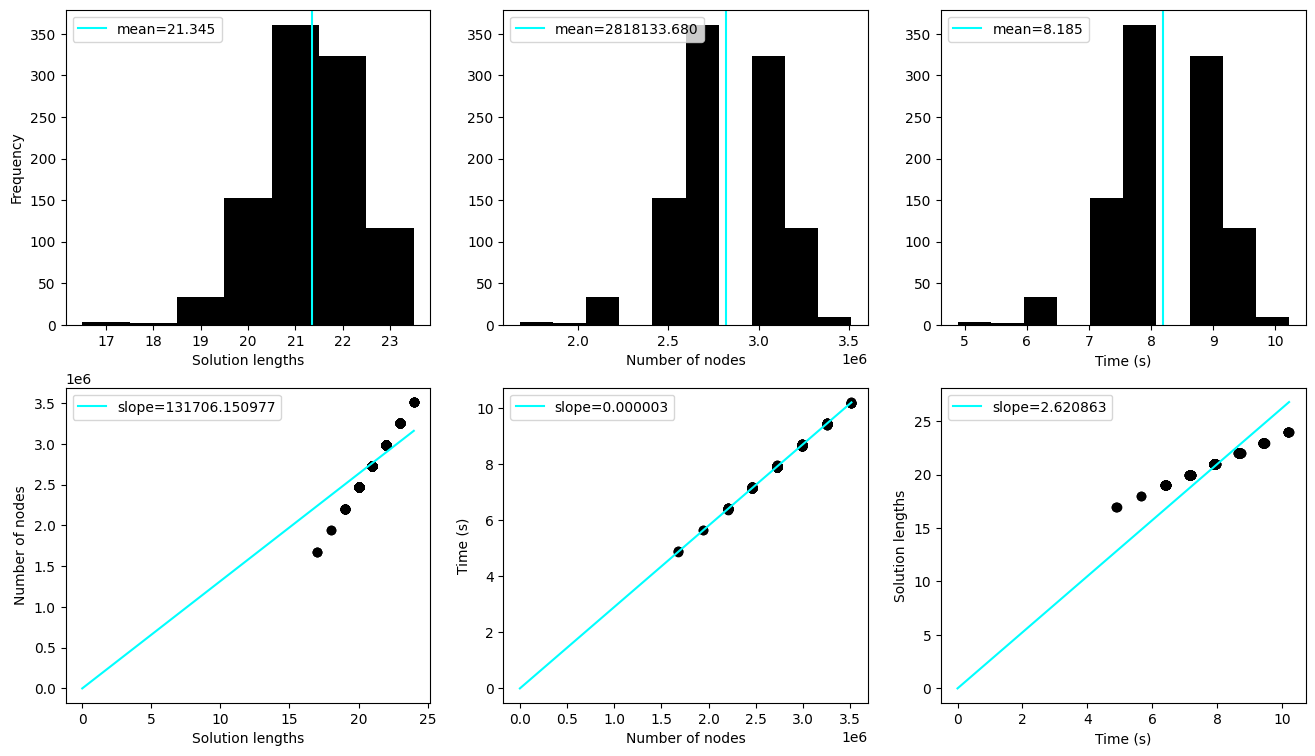

In [51]:
result_ours_plot = result_ours_start_step_2
result_ours_plot['solution_lengths'] = [len(e)+5 for e in result_ours_plot['solution'] if e is not None]
print(f"Average length: {np.mean(result_ours_plot['solution_lengths']):.2f}")
result_ours_plot['solution_lengths_count'] = {
    i: result_ours_plot["solution_lengths"].count(i)
    for i in range(min(result_ours_plot["solution_lengths"]), max(result_ours_plot["solution_lengths"]))
}
result_ours_plot['times'] = [t for t in result_ours_plot['time'] if t is not None]
print(f"Successfully solved {len(result_ours_plot['time'])} cases out of {len(result_ours_plot['solution'])}")
 
average_extra_steps = np.mean([length - optimal for length, optimal in zip(result_ours_plot['solution_lengths'], result_Optimal['solution_lengths'])])
print(f"Average extra steps compared to optimal: {average_extra_steps:.2f}")
print(f"Average length: {np.mean(result_ours_plot['solution_lengths']):.2f}")

# Visualize result0
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours_plot[k]
    if k=="solution_lengths":
        v_count = result_ours_plot['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours_plot[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef, label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

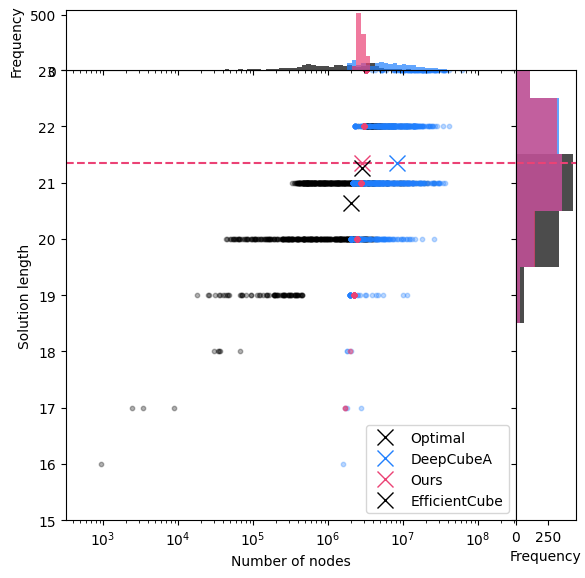

In [53]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]
# plt.rcParams.update(plt.rcParamsDefault)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_ylim(15, max(result_ours_plot['solution_lengths_count']))
ax_histy.set_ylim(15, max(result_ours_plot['solution_lengths_count']))

xmin, xmax = 2.5, 8.5
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################

key_x, key_y = "num_nodes_generated", "solution_lengths"

for k, data in [("Optimal", result_Optimal), ("DeepCubeA", result_DeepCubeA), ("Ours", result_ours_plot)]:
    x, y = data[key_x], data[key_y]
    ax.scatter(x, y, s=10, alpha=0.3)
    ax_histx.hist(x, bins=bins_x, alpha=0.7)

for i, data in enumerate([result_Optimal, result_DeepCubeA, result_ours_plot]):
    data = data["solution_lengths_count"]
    ax_histy.barh(list(data.keys()), list(data.values()), height=1, alpha=0.7)

ax_histy.axhline(np.mean(result_ours_plot[key_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours_plot[key_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_Optimal[key_x]), np.mean(result_Optimal[key_y]),     "x", markersize=12, label="Optimal")
ax.plot(np.mean(result_DeepCubeA[key_x]), np.mean(result_DeepCubeA[key_y]), "x", markersize=12, label="DeepCubeA")
ax.plot(np.mean(result_ours_plot[key_x]), np.mean(result_ours_plot[key_y]),           "x", markersize=12, label="Ours")
ax.plot(np.mean(result_ours_plot[key_x]), 21.26,           "x", markersize=12, label="EfficientCube")
ax.legend()

plt.show()

: 

: 

: 

: 